In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

## Gather the data from qlp and spoc run
Merge that data with the original TIC information on those targets for easy sorting.

In [2]:
qlp_file = "/Users/smullally/Science/tess_false_alarms/vet_results/joe_mar_2021/first-dataset/qlp_noebplanets_tcesum.csv"
spoc_file  = "/Users/smullally/Science/tess_false_alarms/vet_results/joe_mar_2021/first-dataset/spoc_noebplanets_tcesum.csv"

col_names = ["tic","pn","sector","period","epoch","depth","dur","snr","disp","reason", "match"]
qlp_df = pd.read_csv(qlp_file, names=col_names)
spoc_df = pd.read_csv(spoc_file, names=col_names)

In [3]:
qlp_df['uniqueid'] = qlp_df['tic'].str[4:].astype(int)*100+qlp_df['sector']

In [4]:
#Created using uncrowded_kepler_targets.py
targetdf = pd.read_csv("/Users/smullally/Science/tess_false_alarms/keplerTargets/target_selection/target_tic_contamination_20210528.txt")
targetdf['uniqueid'] = targetdf['ticid']*100 + targetdf['sector']

#Merge target information into qlp TCEs.
qlp_tces = pd.merge(qlp_df, targetdf[['Tmag', 'Hmag', 'Vmag','contratio','aperture','uniqueid']], left_on="uniqueid", right_on="uniqueid", how="left" )

## Plot distributions
This shows everything that was found, passing or failling the vetting.

Text(0.5, 0, 'SNR')

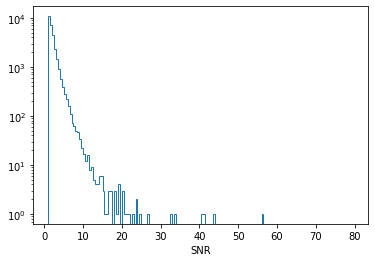

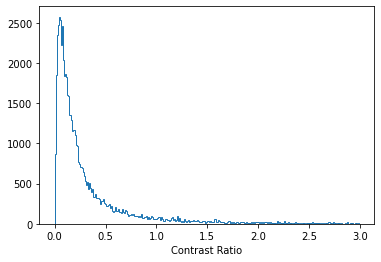

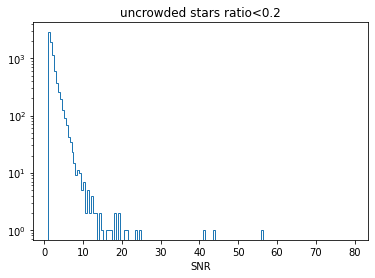

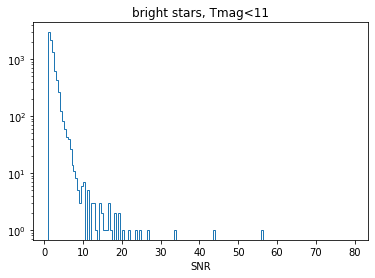

In [5]:
bins = np.arange(1,80,.5)

plt.figure()
n,bins, patches = plt.hist(qlp_tces['snr'],bins = bins,histtype='step')
plt.yscale('log')
plt.xlabel('SNR')


plt.figure()
n, bins, patches = plt.hist(qlp_tces['contratio'], histtype='step', bins=np.arange(0,3,.01))
plt.xlabel('Contrast Ratio')

uncrowded = qlp_tces['contratio'] <= 0.2

plt.figure()
n, bins, patchees = plt.hist(qlp_tces[uncrowded]['snr'], histtype='step',bins=np.arange(1,80,.5))
plt.title('uncrowded stars ratio<0.2')
plt.yscale('log')
plt.xlabel('SNR')

bright = qlp_tces['Tmag'] < 11
plt.figure()
n, bins, patchees = plt.hist(qlp_tces[bright]['snr'], histtype='step',bins=np.arange(1,80,.5))
plt.title('bright stars, Tmag<11')
plt.yscale('log')
plt.xlabel('SNR')


## Investigate the high snr ones.  Can we remove them?

In [6]:
qlp_high_snr = qlp_tces[uncrowded & (qlp_tces.snr > 20)].copy()
qlp_high_snr

tic  pn  sector   period      epoch      depth  dur    snr  \
3651    TIC 120764848   2      14   6.7998  1683.6535  25051.229  1.0  21.46   
10383   TIC 122717066   1      14   7.2938  1690.6344  15644.205  1.0  56.26   
10384   TIC 122717066   2      14   7.3037  1690.6448   4887.575  1.0  24.60   
14281   TIC 123495498   3      26   8.0347  2011.8812  46551.203  1.0  20.60   
31454   TIC 159097856   2      14   8.4385  1690.1763  87987.409  1.0  41.45   
111032   TIC 63126950   2      14  10.6985  1686.1553  27460.368  2.0  43.60   
111033   TIC 63126950   3      14  10.8765  1686.1949   8039.581  1.0  23.97   

         disp                                             reason  match  \
3651     FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
10383    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
10384    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
14281    FAIL                          -NormLPP--SWEETHalfPeriod    NaN   
31454    FAIL   -NormLPP--PoorTransitCoverage--SWEETTwicePeriod-    NaN   
111032   FAIL                                   -SWEETHalfPeriod    NaN   
111033   FAIL            -NormLPP--SWEETHalfPeriod-SWEETAtPeriod    NaN   

           uniqueid      Tmag    Hmag    Vmag  contratio   aperture  
3651    12076484814  12.03620  11.160  12.633   0.105603  31.180285  
10383   12271706614   8.19308   7.937   8.310   0.011333  42.761551  
10384   12271706614   8.19308   7.937   8.310   0.011333  42.761551  
14281   12349549826  11.96380  11.174  12.026   0.126331  31.778070  
31454   15909785614  12.28340  11.533  12.759   0.108655  28.749824  
111032   6312695014   8.27640   7.926   8.470   0.018504  42.374260  
111033   6312695014   8.27640   7.926   8.470   0.018504  42.374260

In [7]:
import exovetter.vetters as vet
import corazon as crz
import lightkurve as lk
from exovetter.tce import Tce
from exovetter import const 

def get_lk(tcedf, author = "qlp", mission = "TESS", size = 11):
    """Returns lc and tpf given a dataframe line"""
    
    ticid = tcedf['tic'][4:]
    sector = tcedf['sector']
    
    lc = crz.gen_lightcurve.hlsp(ticid, sector, author=author)
    tpf = lk.search_tesscut(f"TIC {ticid}", sector = sector).download(cutout_size = size)
    
    return lc, tpf

def make_tce(adf, offset = 0 *u.day):
    
    atce = Tce(period = adf['period'] * u.day,
               epoch = adf['epoch'] *u.day,
               epoch_offset = offset,
               duration=adf['dur'] * u.hr, 
               depth=adf['depth'] * const.ppm,
               snr = adf['snr'])
    
    return atce

def vet_tce(tce, lc, tpf):
    """Pull up plots of the full and folded light curve.
        There are all plot from exovetter
    """
    
    results = []
    
    tc = vet.TransitPhaseCoverage()
    tpc = tc.run(tce,lc)
    results.append(tpc)
    
    try:
        mod = vet.ModShift()
        modshift = mod.run(tce, lc)
        modshift.plot()
        results.append(modshift)
    except:
        pass
    
    sweet = vet.Sweet()
    sweetvet = sweet.run(tce,lc)
    sweet.plot()
    results.append(sweet)
    #cent = vet.Centroid()
    #centout = cent.run(tce, tpf, plot=True)
    #results.append(centout)
    
    #oe = vet.OddEven()
    #oddeven = oe.run(tce,lc)
    #oe.plot()
    #results.append(oddeven)
    
    fold = vet.VizTransits(smooth=8, max_transits=5)
    ntransits = fold.run(tce, lc, plot=True)
    results.append(ntransits)
    
    
    return results

In [8]:
mask = np.zeros(len(qlp_tces)) == 0
mask

array([ True,  True,  True, ...,  True,  True,  True])

tic          TIC 120764848
pn                       1
sector                  14
period              6.7319
epoch            1683.8785
depth            10104.225
dur                    1.0
snr                   6.68
disp                  FAIL
reason           -NormLPP-
match                  NaN
uniqueid       12076484814
Tmag               12.0362
Hmag                 11.16
Vmag                12.633
contratio         0.105603
aperture         31.180285
Name: 3650, dtype: object
[0. 1. 2. 3.]
5
[0. 0. 0. ... 4. 4. 4.]
tic                            TIC 120764848
pn                                         2
sector                                    14
period                                6.7998
epoch                              1683.6535
depth                              25051.229
dur                                      1.0
snr                                    21.46
disp                                    FAIL
reason        -NormLPP--PoorTransitCoverage-
match                    

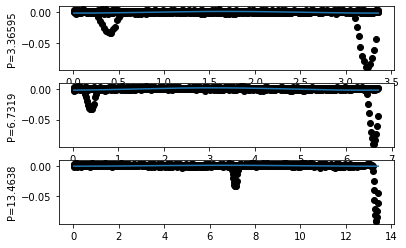

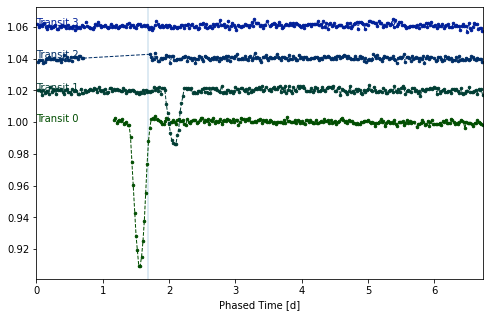

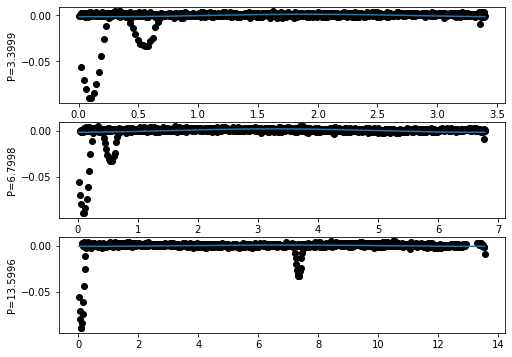

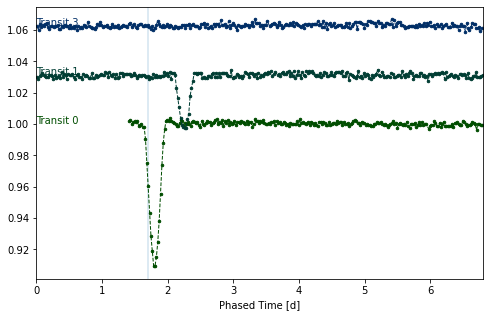

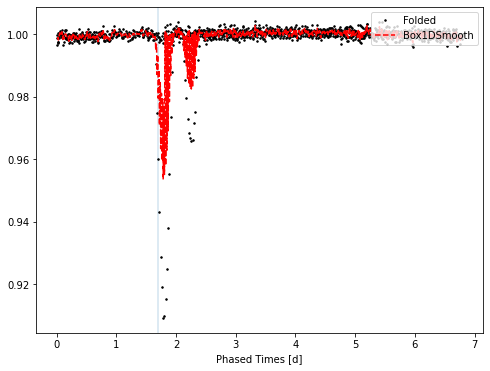

In [9]:
#Vet One
i = 3650;
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i] = False
i = 3651;
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i] = False

tic                            TIC 122717066
pn                                         1
sector                                    14
period                                7.2938
epoch                              1690.6344
depth                              15644.205
dur                                      1.0
snr                                    56.26
disp                                    FAIL
reason        -NormLPP--PoorTransitCoverage-
match                                    NaN
uniqueid                         12271706614
Tmag                                 8.19308
Hmag                                   7.937
Vmag                                    8.31
contratio                           0.011333
aperture                           42.761551
Name: 10383, dtype: object
[-1.  0.  1.  2.]
4
[-1. -1. -1. ...  2.  2.  2.]
tic                            TIC 122717066
pn                                         2
sector                                    14
period                 

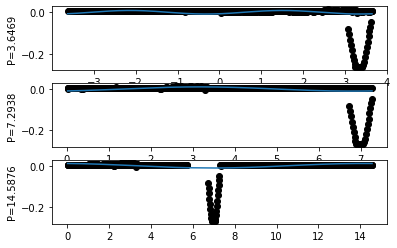

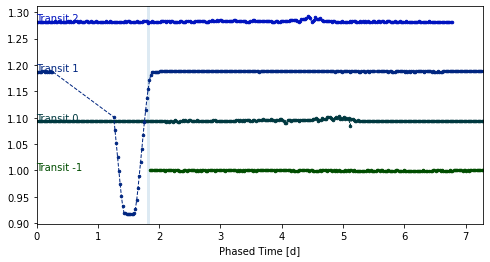

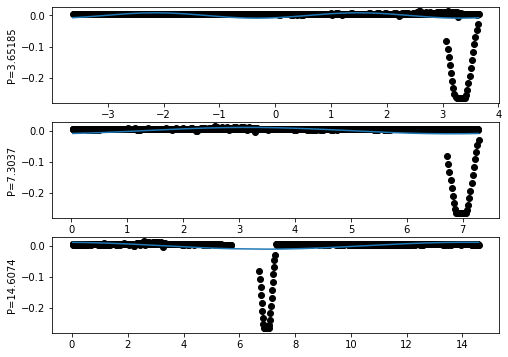

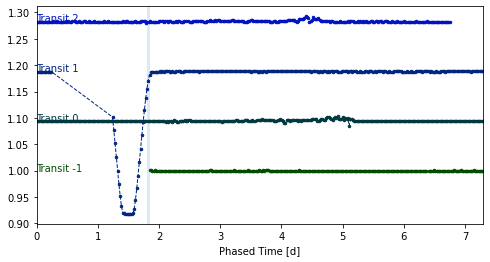

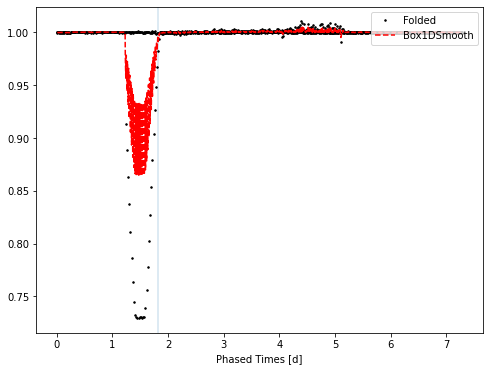

In [10]:
#Vet One
i = 10383;
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i] = False
i = 10384;
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i] = False
#known EB

(1697.0, 1699.0)

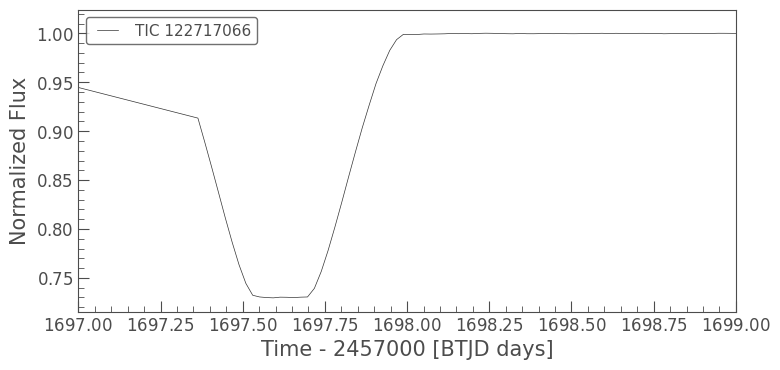

In [11]:
alc.plot()
plt.xlim(1697,1699)

tic                       TIC 123495498
pn                                    3
sector                               26
period                           8.0347
epoch                         2011.8812
depth                         46551.203
dur                                 1.0
snr                                20.6
disp                               FAIL
reason        -NormLPP--SWEETHalfPeriod
match                               NaN
uniqueid                    12349549826
Tmag                            11.9638
Hmag                             11.174
Vmag                             12.026
contratio                      0.126331
aperture                       31.77807
Name: 14281, dtype: object
[0. 1. 2.]
4
[0. 0. 0. ... 3. 3. 3.]


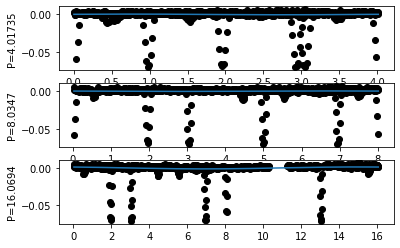

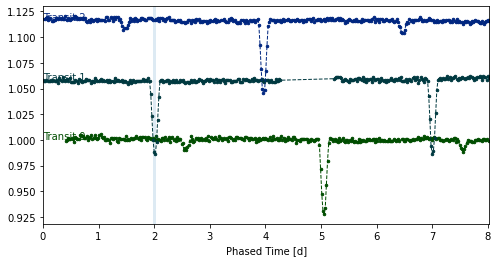

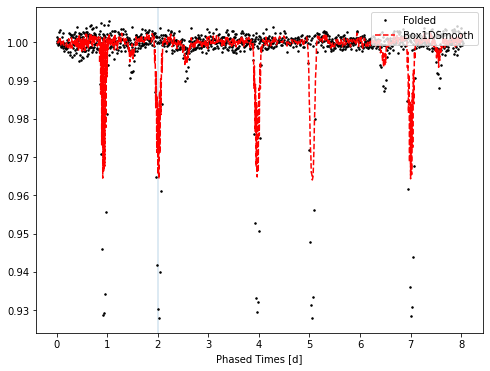

In [12]:
#Vet One
i = 14281;
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i] = False
#This is a CO from a known EB

tic                                              TIC 159097856
pn                                                           2
sector                                                      14
period                                                  8.4385
epoch                                                1690.1763
depth                                                87987.409
dur                                                        1.0
snr                                                      41.45
disp                                                      FAIL
reason        -NormLPP--PoorTransitCoverage--SWEETTwicePeriod-
match                                                      NaN
uniqueid                                           15909785614
Tmag                                                   12.2834
Hmag                                                    11.533
Vmag                                                    12.759
contratio                                             0

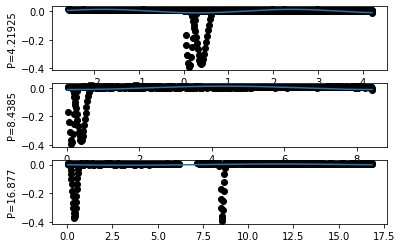

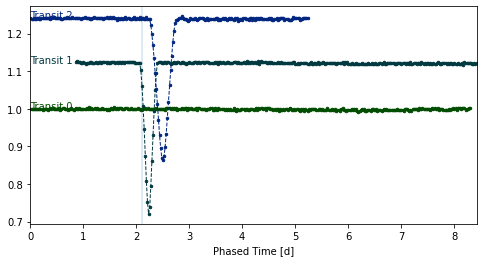

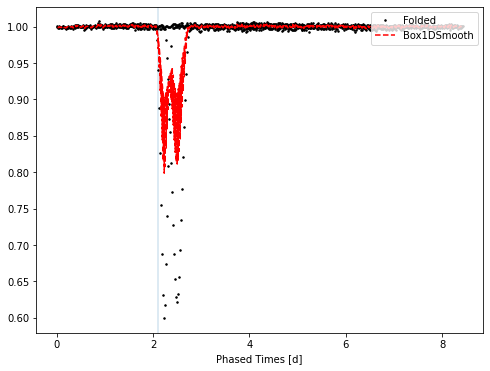

In [13]:
#Vet One
i = 31454
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i] = False #Edge of a known EB


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

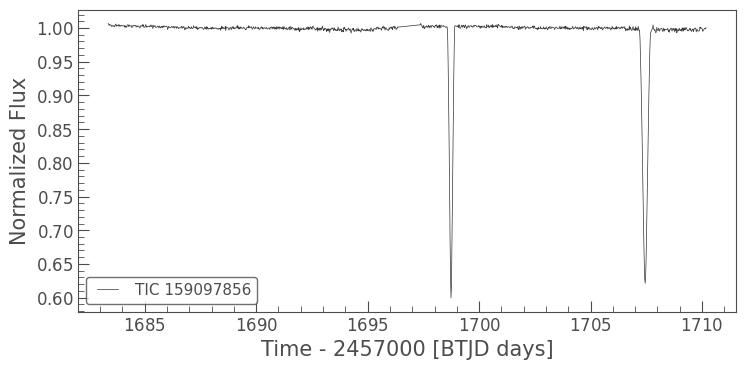

In [14]:
alc.plot()

tic               TIC 63126950
pn                           2
sector                      14
period                 10.6985
epoch                1686.1553
depth                27460.368
dur                        2.0
snr                       43.6
disp                      FAIL
reason        -SWEETHalfPeriod
match                      NaN
uniqueid            6312695014
Tmag                    8.2764
Hmag                     7.926
Vmag                      8.47
contratio             0.018504
aperture              42.37426
Name: 111032, dtype: object
[0. 2.]
4
[-1. -1. -1. ...  2.  2.  2.]


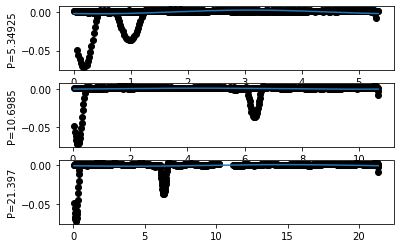

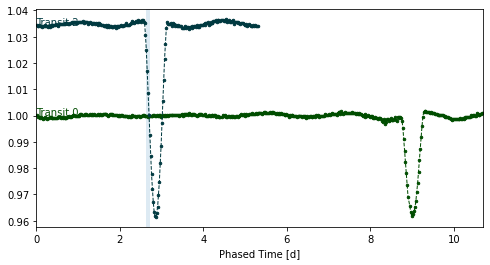

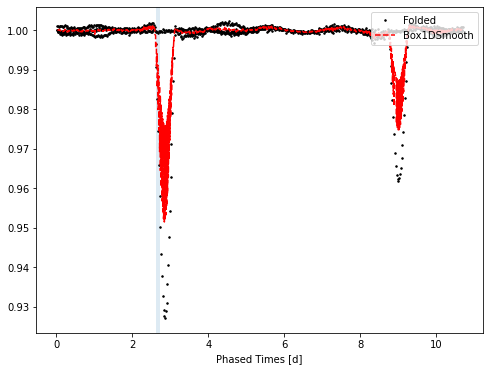

In [15]:
#Vet One
i = 111032
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i] = False #Known EB

In [16]:
qlp_high_snr = qlp_tces[mask & (qlp_tces.snr > 20)].copy()
qlp_high_snr

tic  pn  sector   period      epoch       depth  dur    snr  \
19744   TIC 138639275   1      14   8.7529  1684.7135   99711.405  4.0  20.22   
32244   TIC 159180123   2      14   8.5117  1687.9242   48568.824  1.0  32.99   
57596    TIC 26542657   3      14   9.7333  1690.8617    8834.613  1.0  21.66   
57601    TIC 26542657   3      15  10.3892  1712.8996   11681.441  2.0  33.85   
61296   TIC 268381034   3      15   8.5423  1718.8847  156875.811  1.0  26.63   
90381    TIC 27845677   1      14  10.2654  1685.9803   55161.940  1.0  20.10   
90382    TIC 27845677   2      14  10.3990  1685.9844   54563.266  1.0  40.78   
96257   TIC 299096335   2      14   7.2919  1689.2182  107019.068  1.0  22.90   
101600  TIC 378084507   2      14   8.7919  1691.1342   21792.678  1.0  20.24   
109569   TIC 48507024   4      26   9.4189  2016.2809  159879.090  1.0  23.81   
111033   TIC 63126950   3      14  10.8765  1686.1949    8039.581  1.0  23.97   

         disp                                             reason  match  \
19744    FAIL                                          -NormLPP-    NaN   
32244    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
57596    FAIL   -NormLPP--PoorTransitCoverage--SWEETHalfPerio...    NaN   
57601    FAIL                          -NormLPP--SWEETHalfPeriod    NaN   
61296    FAIL   -NormLPP--PoorTransitCoverage--SWEETHalfPerio...    NaN   
90381    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
90382    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
96257    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
101600   FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
109569   FAIL     -NormLPP--PoorTransitCoverage--SWEETHalfPeriod    NaN   
111033   FAIL            -NormLPP--SWEETHalfPeriod-SWEETAtPeriod    NaN   

           uniqueid     Tmag    Hmag    Vmag  contratio   aperture  
19744   13863927514  12.3775  11.059  13.196        NaN  27.634799  
32244   15918012314  11.7540  11.129  12.344   0.756855  33.273257  
57596    2654265714   8.6260   7.978   9.267   0.938600  41.007959  
57601    2654265715   8.6260   7.978   9.267   0.938600  41.007959  
61296   26838103415  10.7863   8.894  11.651        NaN  37.106530  
90381    2784567714  11.1980  10.760  11.499        NaN  35.945982  
90382    2784567714  11.1980  10.760  11.499        NaN  35.945982  
96257   29909633514  12.8497  11.555  13.683        NaN  19.468554  
101600  37808450714   9.6295   8.276  10.439        NaN  38.829850  
109569   4850702426  11.4695   9.908  12.364        NaN  34.837939  
111033   6312695014   8.2764   7.926   8.470   0.018504  42.374260

### Interesting
The target below is potentially interesting
It has a variable Kepler ligth curve and it doesn't appear to be a known EB. The Centroid offset puts inon our target, or within a pixel.

tic          TIC 138639275
pn                       1
sector                  14
period              8.7529
epoch            1684.7135
depth            99711.405
dur                    4.0
snr                  20.22
disp                  FAIL
reason           -NormLPP-
match                  NaN
uniqueid       13863927514
Tmag               12.3775
Hmag                11.059
Vmag                13.196
contratio              NaN
aperture         27.634799
Name: 19744, dtype: object
[0. 1. 2.]
4
[0. 0. 0. ... 3. 3. 3.]


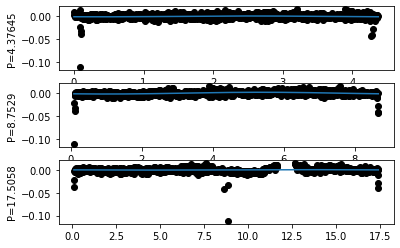

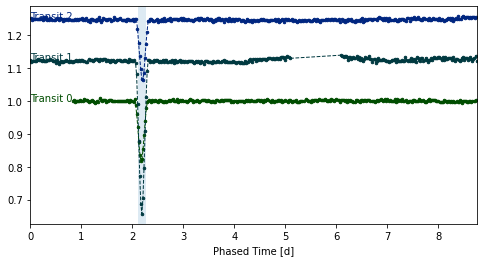

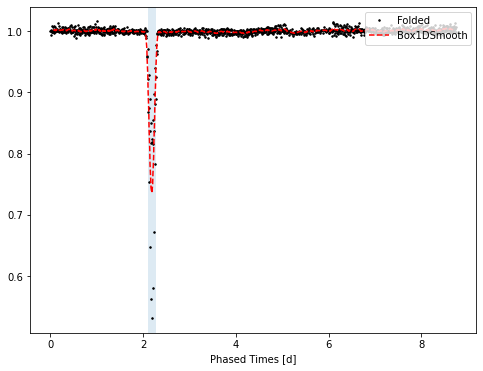

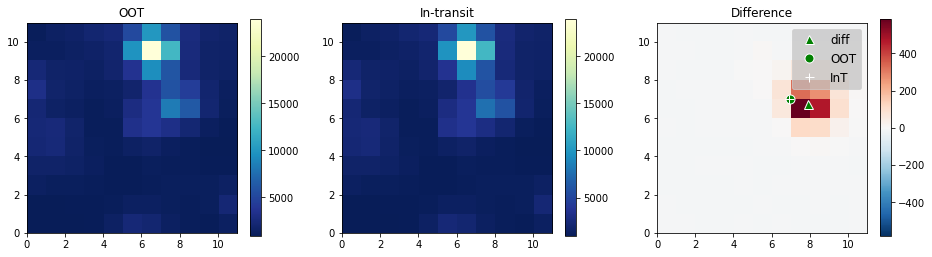

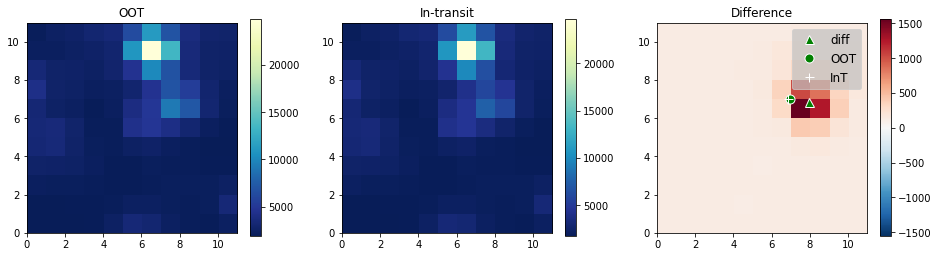

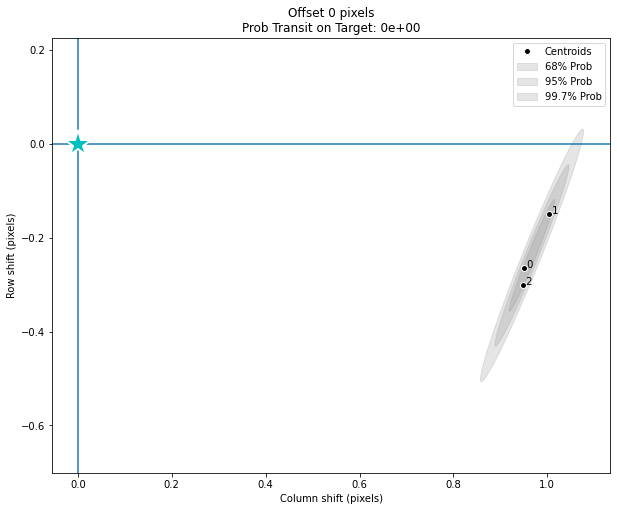

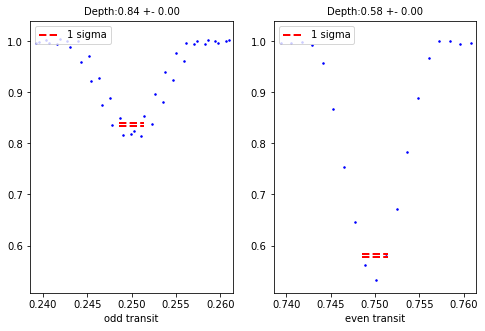

In [17]:
#Vet One
i = 19744
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
oe = vet.OddEven()
oddeven = oe.run(atce, alc)
oe.plot()
mask[i] = False 
#Not a known EB. #Kep light curve is very variable. #Potentially interesting.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

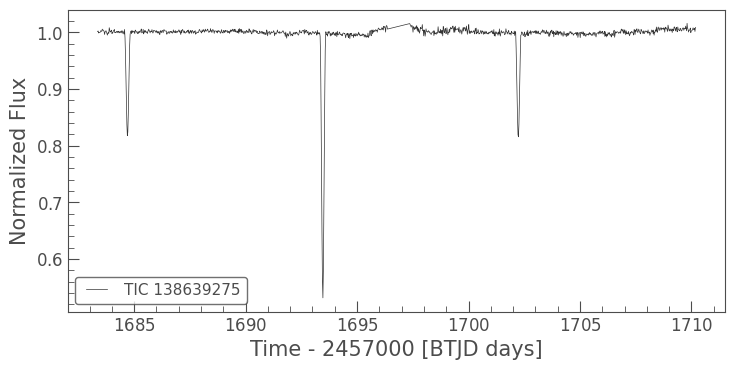

In [18]:
alc.plot()

tic                            TIC 159180123
pn                                         2
sector                                    14
period                                8.5117
epoch                              1687.9242
depth                              48568.824
dur                                      1.0
snr                                    32.99
disp                                    FAIL
reason        -NormLPP--PoorTransitCoverage-
match                                    NaN
uniqueid                         15918012314
Tmag                                  11.754
Hmag                                  11.129
Vmag                                  12.344
contratio                           0.756855
aperture                           33.273257
Name: 32244, dtype: object
[0. 2.]
4
[-1. -1. -1. ...  2.  2.  2.]


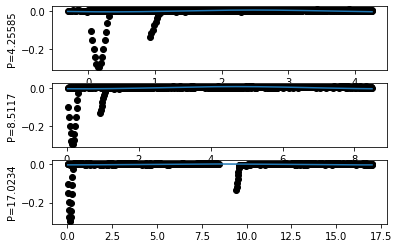

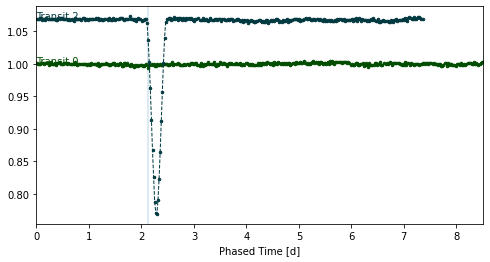

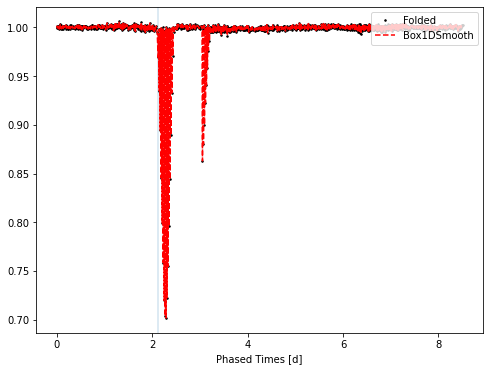

In [19]:
i=32244
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i] = False #Known EB

/Users/smullally/miniconda3/envs/exovetter/lib/python3.7/site-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,


tic          TIC 26542657
pn                      1
sector                 14
period             9.7114
epoch           1690.9659
depth           16299.215
dur                   4.0
snr                 11.19
disp                 PASS
reason                   
match                 NaN
uniqueid       2654265714
Tmag                8.626
Hmag                7.978
Vmag                9.267
contratio          0.9386
aperture        41.007959
Name: 57594, dtype: object
[0. 1. 2.]
4
[-1. -1. -1. ...  2.  2.  2.]


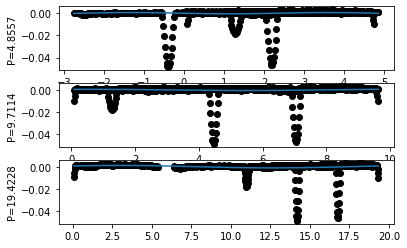

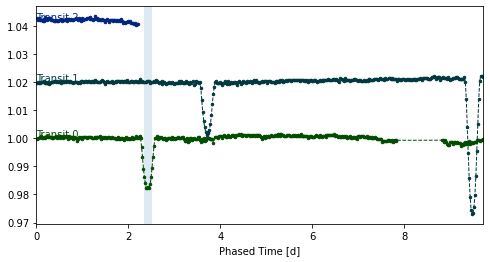

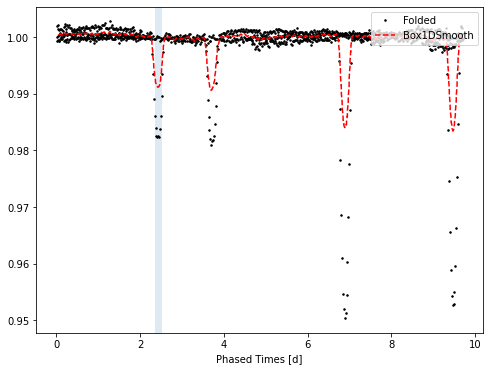

In [20]:
i=57594
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i] = False #Known TESS EB

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

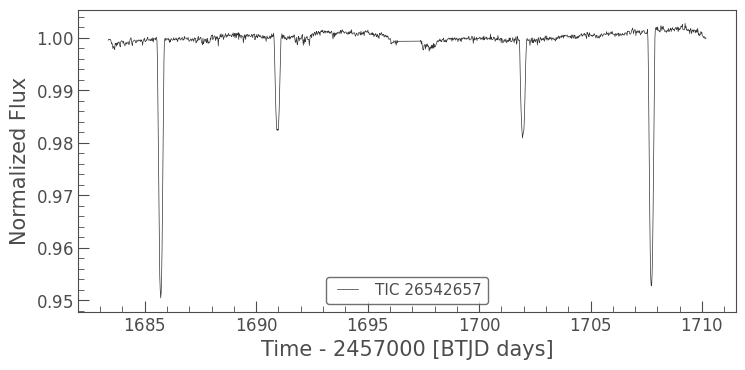

In [21]:
alc.plot()

/Users/smullally/miniconda3/envs/exovetter/lib/python3.7/site-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,


tic                        TIC 26542657
pn                                    3
sector                               15
period                          10.3892
epoch                         1712.8996
depth                         11681.441
dur                                 2.0
snr                               33.85
disp                               FAIL
reason        -NormLPP--SWEETHalfPeriod
match                               NaN
uniqueid                     2654265715
Tmag                              8.626
Hmag                              7.978
Vmag                              9.267
contratio                        0.9386
aperture                      41.007959
Name: 57601, dtype: object
[0. 1. 2.]
3
[0. 0. 0. ... 2. 2. 2.]


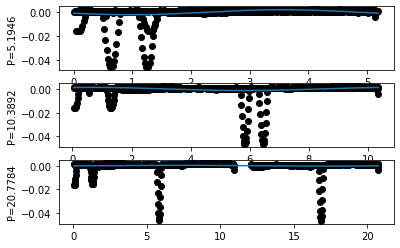

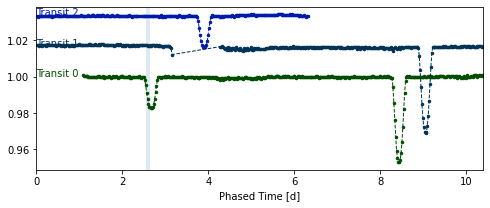

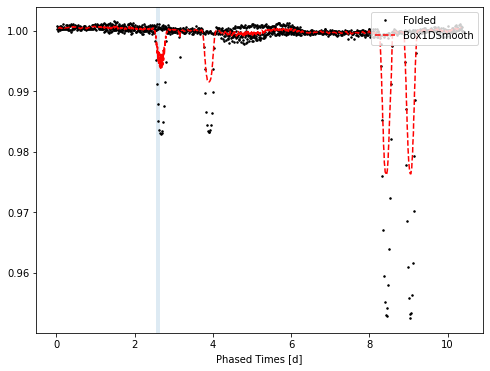

In [22]:
i=57601
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i] = False #Known TESS EB
mask[i-1] = False
mask[i-2] = False

### Interesting Target. Unknown Binary

tic                                             TIC 268381034
pn                                                          1
sector                                                     15
period                                                 4.3207
epoch                                               1714.2618
depth                                               234131.32
dur                                                       8.0
snr                                                      7.02
disp                                                     FAIL
reason        -OddEvenDetected--SWEETHalfPeriod-SWEETAtPeriod
match                                                     NaN
uniqueid                                          26838103415
Tmag                                                  10.7863
Hmag                                                    8.894
Vmag                                                   11.651
contratio                                                 NaN
aperture

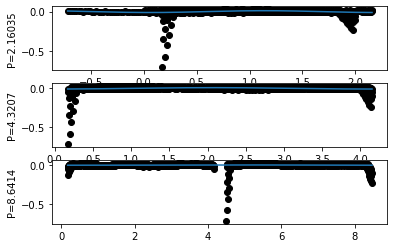

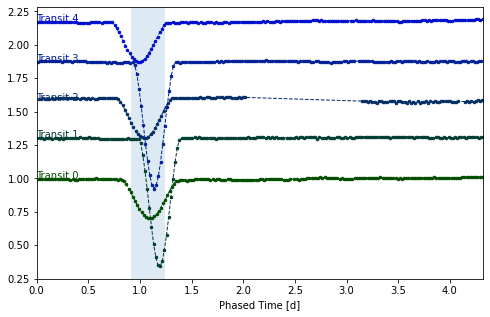

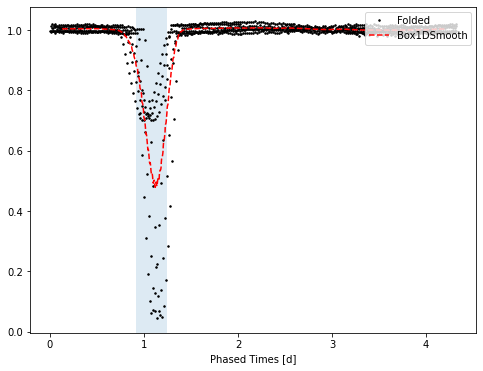

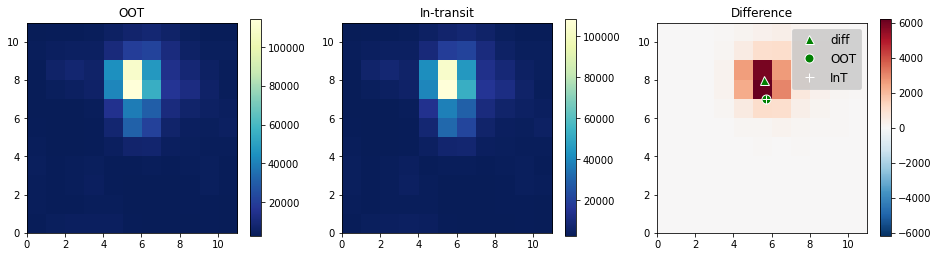

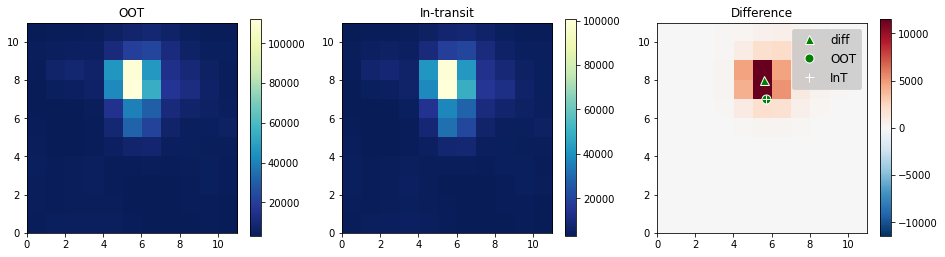

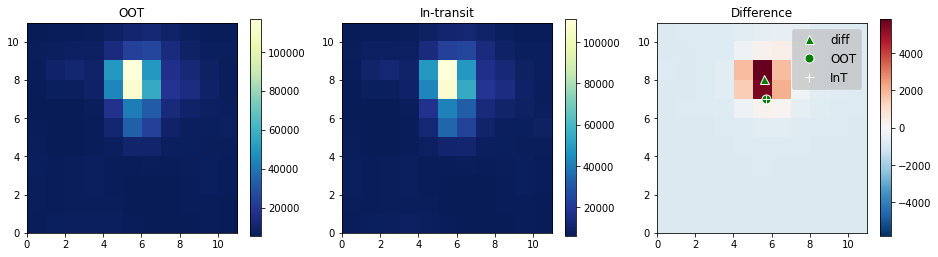

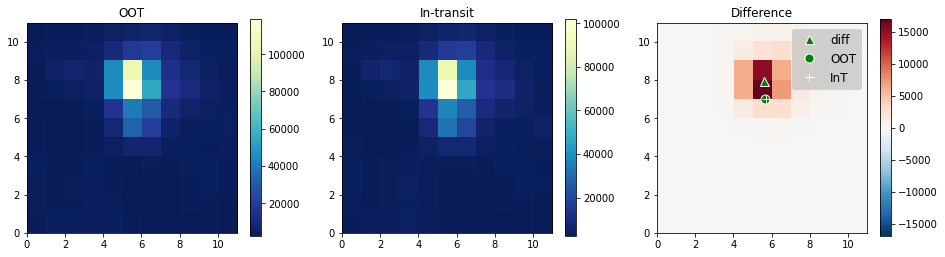

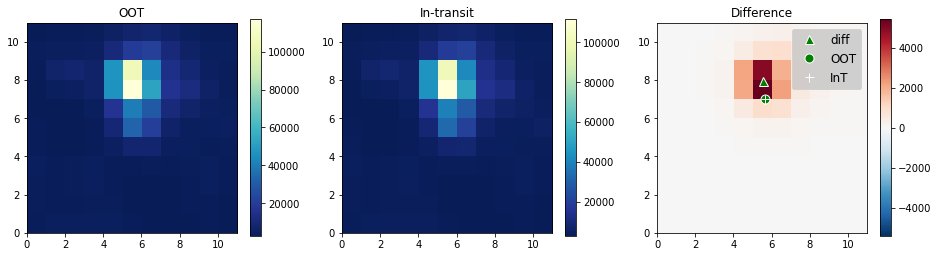

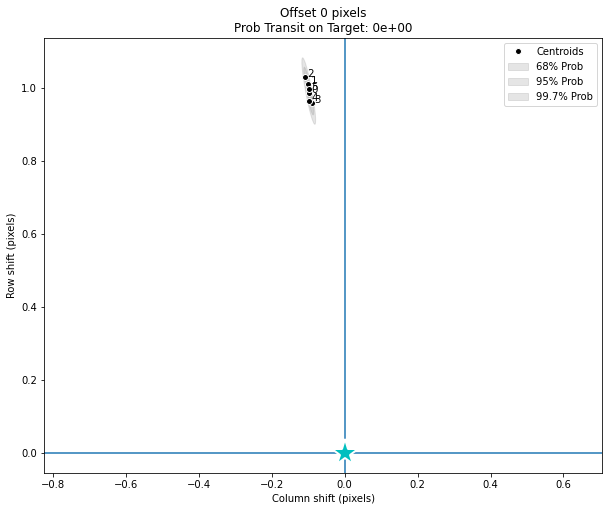

In [23]:
i = 61294
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
oe = vet.OddEven()
mask[i:i+3] = [False,False,False] #Appears to be an EB on TIC 268381049 (check)

In [24]:
qlp_high_snr = qlp_tces[mask & (qlp_tces.snr > 20)].copy()
qlp_high_snr

tic  pn  sector   period      epoch       depth  dur    snr  \
57596    TIC 26542657   3      14   9.7333  1690.8617    8834.613  1.0  21.66   
90381    TIC 27845677   1      14  10.2654  1685.9803   55161.940  1.0  20.10   
90382    TIC 27845677   2      14  10.3990  1685.9844   54563.266  1.0  40.78   
96257   TIC 299096335   2      14   7.2919  1689.2182  107019.068  1.0  22.90   
101600  TIC 378084507   2      14   8.7919  1691.1342   21792.678  1.0  20.24   
109569   TIC 48507024   4      26   9.4189  2016.2809  159879.090  1.0  23.81   
111033   TIC 63126950   3      14  10.8765  1686.1949    8039.581  1.0  23.97   

         disp                                             reason  match  \
57596    FAIL   -NormLPP--PoorTransitCoverage--SWEETHalfPerio...    NaN   
90381    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
90382    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
96257    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
101600   FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
109569   FAIL     -NormLPP--PoorTransitCoverage--SWEETHalfPeriod    NaN   
111033   FAIL            -NormLPP--SWEETHalfPeriod-SWEETAtPeriod    NaN   

           uniqueid     Tmag    Hmag    Vmag  contratio   aperture  
57596    2654265714   8.6260   7.978   9.267   0.938600  41.007959  
90381    2784567714  11.1980  10.760  11.499        NaN  35.945982  
90382    2784567714  11.1980  10.760  11.499        NaN  35.945982  
96257   29909633514  12.8497  11.555  13.683        NaN  19.468554  
101600  37808450714   9.6295   8.276  10.439        NaN  38.829850  
109569   4850702426  11.4695   9.908  12.364        NaN  34.837939  
111033   6312695014   8.2764   7.926   8.470   0.018504  42.374260

/Users/smullally/miniconda3/envs/exovetter/lib/python3.7/site-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,


tic                             TIC 27845677
pn                                         1
sector                                    14
period                               10.2654
epoch                              1685.9803
depth                               55161.94
dur                                      1.0
snr                                     20.1
disp                                    FAIL
reason        -NormLPP--PoorTransitCoverage-
match                                    NaN
uniqueid                          2784567714
Tmag                                  11.198
Hmag                                   10.76
Vmag                                  11.499
contratio                                NaN
aperture                           35.945982
Name: 90381, dtype: object
[0. 1. 2.]
4
[-1. -1. -1. ...  2.  2.  2.]


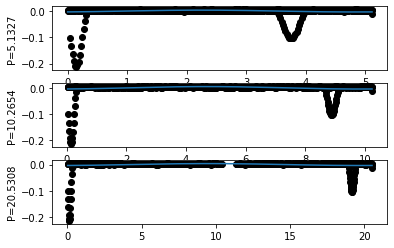

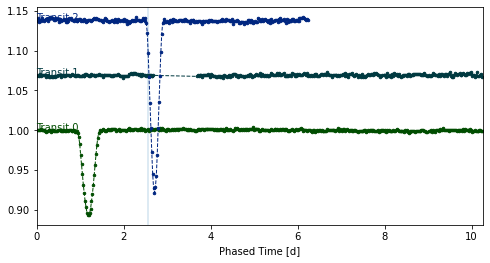

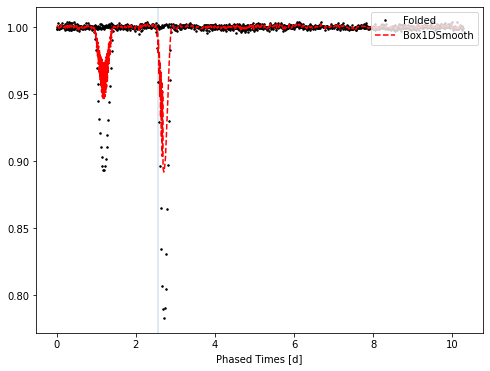

In [25]:
i = 90381
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i] = False #Known TESS EB
mask[i+1] = False

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

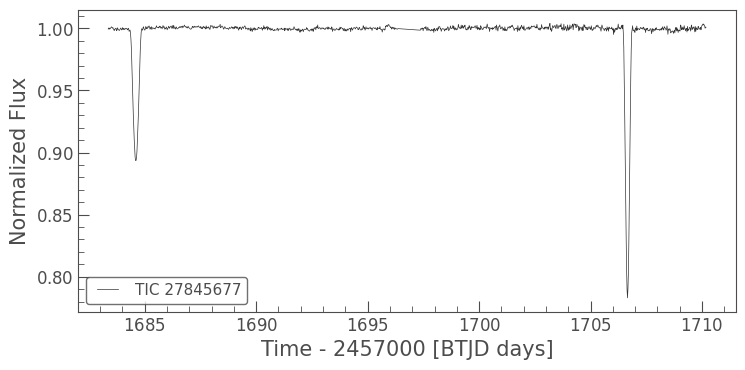

In [26]:
alc.plot()

In [27]:
outmask = "/Users/smullally/Science/tess_false_alarms/vet_results/joe_mar_2021/first-dataset/qlp_noebplanets_tces_mask.csv"
np.savetxt(outmask, mask, fmt="%r")

tic          TIC 299096335
pn                       1
sector                  14
period              7.1898
epoch             1689.214
depth            45596.744
dur                    1.0
snr                   7.09
disp                  FAIL
reason           -NormLPP-
match                  NaN
uniqueid       29909633514
Tmag               12.8497
Hmag                11.555
Vmag                13.683
contratio              NaN
aperture         19.468554
Name: 96256, dtype: object
[0. 1. 2.]
5
[-1. -1. -1. ...  3.  3.  3.]


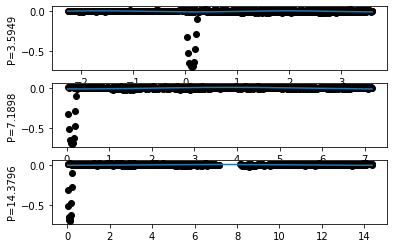

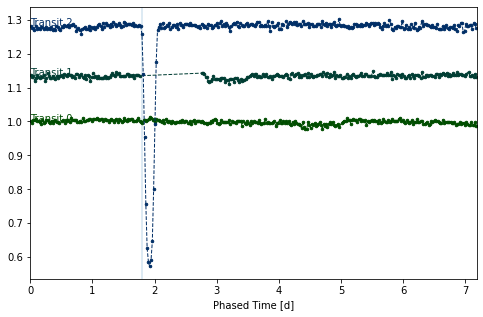

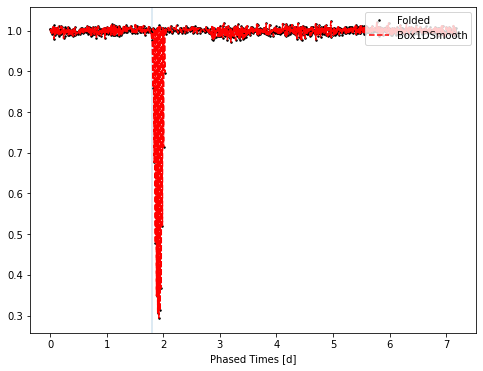

In [28]:
i = 96256
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i] = False #EB KIC 12644769 41 day period.

tic                            TIC 378084507
pn                                         2
sector                                    14
period                                8.7919
epoch                              1691.1342
depth                              21792.678
dur                                      1.0
snr                                    20.24
disp                                    FAIL
reason        -NormLPP--PoorTransitCoverage-
match                                    NaN
uniqueid                         37808450714
Tmag                                  9.6295
Hmag                                   8.276
Vmag                                  10.439
contratio                                NaN
aperture                            38.82985
Name: 101600, dtype: object
[0. 1. 2.]
4
[-1. -1. -1. ...  2.  2.  2.]


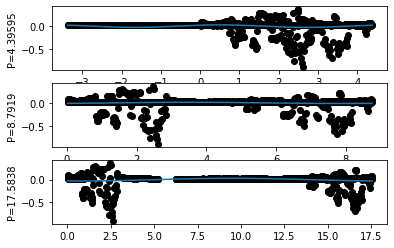

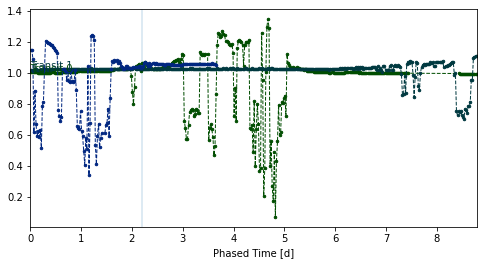

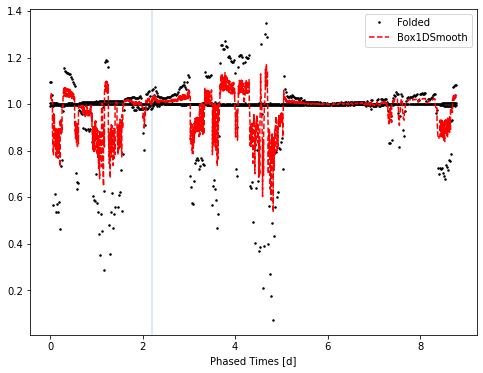

In [29]:
i = 101600
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i] = True  #Lots of noise

tic                          TIC 48507024
pn                                      1
sector                                 26
period                            10.1724
epoch                           2011.0913
depth                           50178.436
dur                                   8.0
snr                                  2.26
disp                                 FAIL
reason        -NormLPP--SWEETTwicePeriod-
match                                 NaN
uniqueid                       4850702426
Tmag                              11.4695
Hmag                                9.908
Vmag                               12.364
contratio                             NaN
aperture                        34.837939
Name: 109566, dtype: object
[0. 1. 2.]
3
[0. 0. 0. ... 2. 2. 2.]


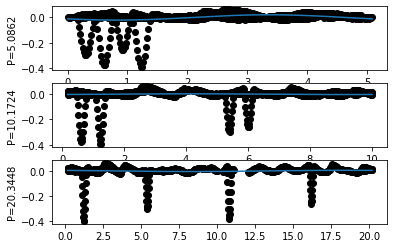

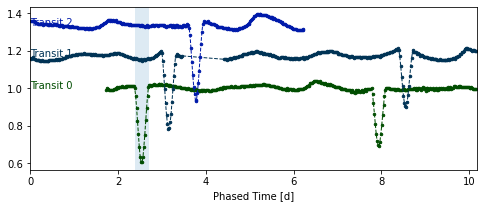

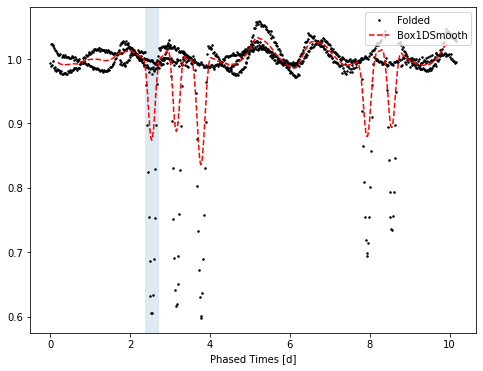

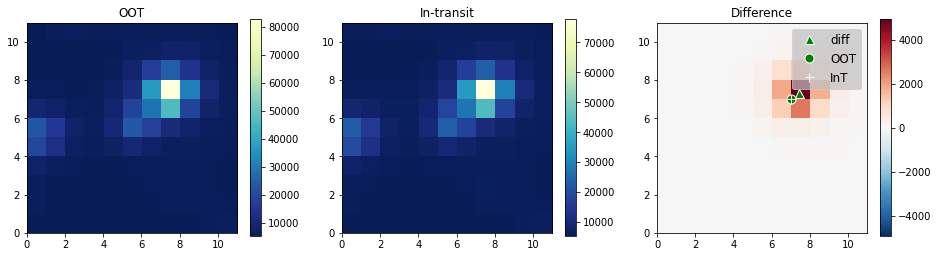

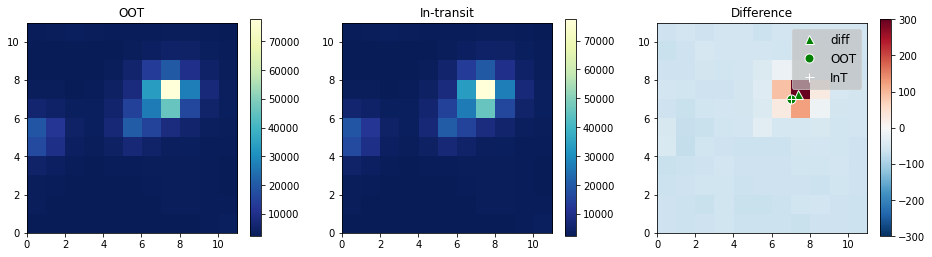

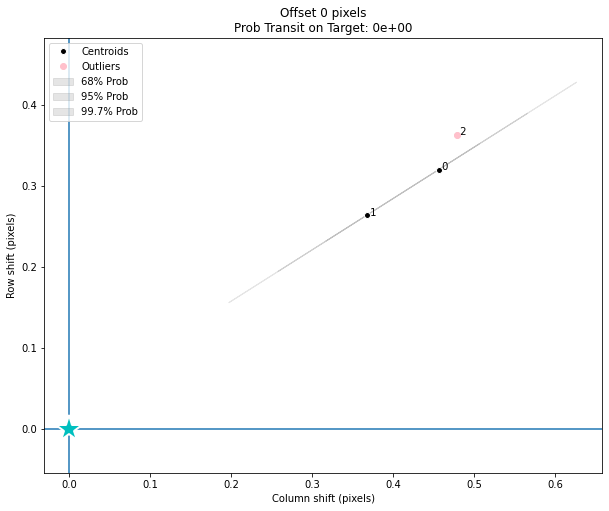

In [30]:
i = 109566
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
mask[i:i+4] = [False,False,False,False]  # EB 11285625

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

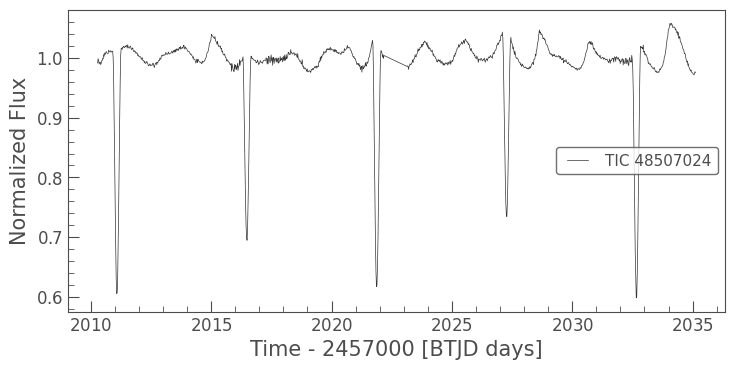

In [31]:
alc.plot()

tic                        TIC 63126950
pn                                    1
sector                               14
period                          10.8875
epoch                         1686.1324
depth                         12985.295
dur                                 2.0
snr                                6.79
disp                               FAIL
reason        -NormLPP--SWEETHalfPeriod
match                               NaN
uniqueid                     6312695014
Tmag                             8.2764
Hmag                              7.926
Vmag                               8.47
contratio                      0.018504
aperture                       42.37426
Name: 111031, dtype: object
[0. 2.]
4
[-1. -1. -1. ...  2.  2.  2.]


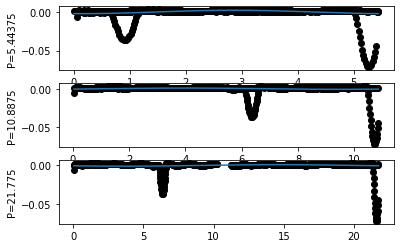

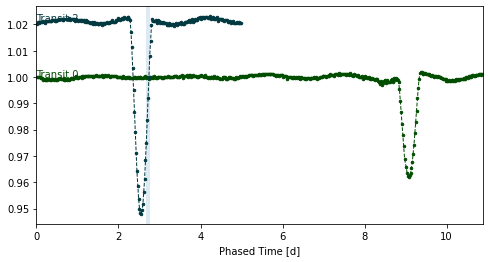

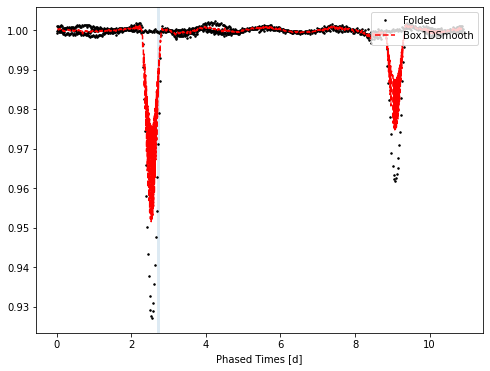

In [32]:
i = 111031
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
mask[i:i+3] = [False,False,False] #Known Kepler EB 8560861

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

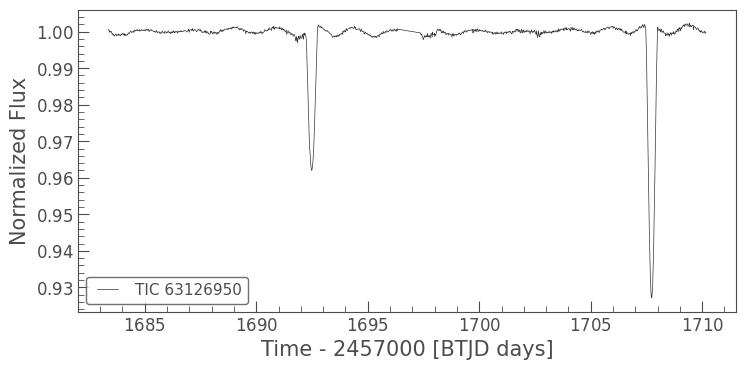

In [33]:
alc.plot()

In [34]:
outmask = "/Users/smullally/Science/tess_false_alarms/vet_results/joe_mar_2021/first-dataset/qlp_noebplanets_tces_mask.csv"
np.savetxt(outmask, mask, fmt="%r")

In [35]:
qlp_high_snr = qlp_tces[mask & (qlp_tces.snr > 20)].copy()
qlp_high_snr

tic  pn  sector  period      epoch       depth  dur    snr  \
57596    TIC 26542657   3      14  9.7333  1690.8617    8834.613  1.0  21.66   
96257   TIC 299096335   2      14  7.2919  1689.2182  107019.068  1.0  22.90   
101600  TIC 378084507   2      14  8.7919  1691.1342   21792.678  1.0  20.24   

         disp                                             reason  match  \
57596    FAIL   -NormLPP--PoorTransitCoverage--SWEETHalfPerio...    NaN   
96257    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
101600   FAIL                     -NormLPP--PoorTransitCoverage-    NaN   

           uniqueid     Tmag    Hmag    Vmag  contratio   aperture  
57596    2654265714   8.6260   7.978   9.267     0.9386  41.007959  
96257   29909633514  12.8497  11.555  13.683        NaN  19.468554  
101600  37808450714   9.6295   8.276  10.439        NaN  38.829850

Text(0.5, 0, 'SNR')

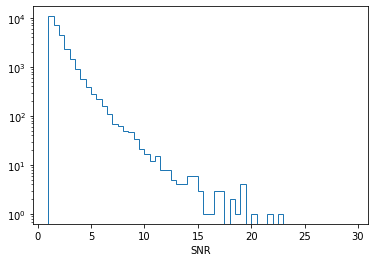

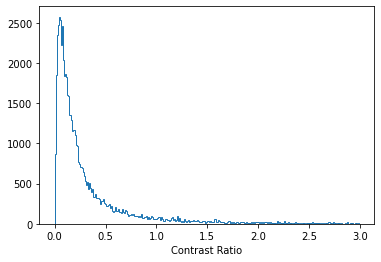

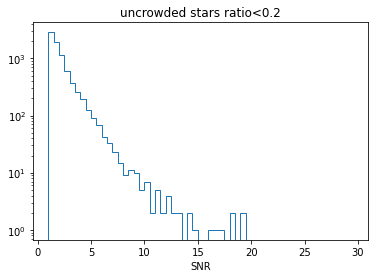

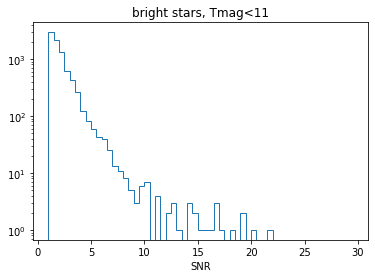

In [36]:
bins = np.arange(1,30,.5)

plt.figure()
n,bins, patches = plt.hist(qlp_tces[mask]['snr'],bins = bins,histtype='step')
plt.yscale('log')
plt.xlabel('SNR')


plt.figure()
n, bins, patches = plt.hist(qlp_tces[mask]['contratio'], histtype='step', bins=np.arange(0,3,.01))
plt.xlabel('Contrast Ratio')

uncrowded = qlp_tces['contratio'] <= 0.2

plt.figure()
n, bins, patchees = plt.hist(qlp_tces[uncrowded & mask]['snr'], histtype='step',bins=np.arange(1,30,.5))
plt.title('uncrowded stars ratio<0.2')
plt.yscale('log')
plt.xlabel('SNR')

bright = qlp_tces['Tmag'] < 11
plt.figure()
n, bins, patchees = plt.hist(qlp_tces[bright & mask]['snr'], histtype='step',bins=np.arange(1,30,.5))
plt.title('bright stars, Tmag<11')
plt.yscale('log')
plt.xlabel('SNR')

In [37]:
qlp_high_snr = qlp_tces[mask & (qlp_tces.snr > 15)].copy()
qlp_high_snr

tic  pn  sector   period      epoch       depth  dur    snr  \
1358    TIC 120320470   3      26  10.5671  2014.4254    3788.646  1.0  16.65   
1868    TIC 120422998   3      26  10.5540  2013.2191    9481.319  1.0  17.00   
1869    TIC 120422998   4      26   8.4801  2013.3046    7223.270  1.0  16.33   
11853   TIC 123313769   1      26  10.6168  2020.8773   17490.805  1.0  19.14   
12647   TIC 123364416   1      26  10.6045  2020.8670    7099.109  1.0  15.53   
24544   TIC 158324584   1      26  10.7199  2013.6998   42724.622  1.0  15.29   
31455   TIC 159097856   3      14   8.6692  1690.1951   28784.399  1.0  19.48   
32243   TIC 159180123   1      14   8.6586  1687.9221   48804.613  1.0  18.64   
34282   TIC 159573320   1      14  10.8766  1687.4658    6943.255  4.0  19.42   
38566   TIC 164658643   1      26   8.7737  2017.6539   29836.981  4.0  15.14   
40903   TIC 164882231   2      26  10.4597  2014.4500    8480.339  1.0  16.54   
44686   TIC 170253873   1      14   6.1937  1684.8403   84056.460  4.0  19.24   
49180   TIC 184008814   3      15   6.1702  1713.2098  108715.548  4.0  18.23   
52512   TIC 185109901   1      15   4.3236  1712.3304   43349.705  4.0  17.08   
57596    TIC 26542657   3      14   9.7333  1690.8617    8834.613  1.0  21.66   
86049   TIC 274118370   2      15  10.6298  1718.0888   41692.429  8.0  17.11   
90383    TIC 27845677   3      14  10.4091  1685.9844   16453.270  1.0  15.43   
96257   TIC 299096335   2      14   7.2919  1689.2182  107019.068  1.0  22.90   
96266   TIC 299096355   1      26   9.6266  2016.3035   20927.799  1.0  16.75   
101600  TIC 378084507   2      14   8.7919  1691.1342   21792.678  1.0  20.24   
111034   TIC 63126950   4      14  10.6509  1686.1887    5345.809  1.0  18.07   

         disp                                             reason  match  \
1358     FAIL                                          -NormLPP-    NaN   
1868     FAIL                                          -NormLPP-    NaN   
1869     FAIL                          -NormLPP--SWEETHalfPeriod    NaN   
11853    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
12647    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
24544    FAIL                                          -NormLPP-    NaN   
31455    FAIL                        -NormLPP--SWEETTwicePeriod-    NaN   
32243    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
34282    FAIL                                          -NormLPP-    NaN   
38566    FAIL                                 -SWEETTwicePeriod-    NaN   
40903    FAIL                                          -NormLPP-    NaN   
44686    PASS                                                       NaN   
49180    FAIL   -SWEETHalfPeriod-SWEETAtPeriod-SWEETTwicePeriod-    NaN   
52512    FAIL            -NormLPP--SWEETHalfPeriod-SWEETAtPeriod    NaN   
57596    FAIL   -NormLPP--PoorTransitCoverage--SWEETHalfPerio...    NaN   
86049    FAIL   -NormLPP--SWEETHalfPeriod-SWEETAtPeriod-SWEET...    NaN   
90383    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
96257    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
96266    FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
101600   FAIL                     -NormLPP--PoorTransitCoverage-    NaN   
111034   FAIL            -NormLPP--SWEETHalfPeriod-SWEETAtPeriod    NaN   

           uniqueid      Tmag    Hmag    Vmag  contratio   aperture  
1358    12032047026   7.48500   4.545  10.587        NaN  47.125533  
1868    12042299826   9.60726   9.108   9.992   0.045817  38.860428  
1869    12042299826   9.60726   9.108   9.992   0.045817  38.860428  
11853   12331376926   9.78200   3.111  15.394        NaN  38.629397  
12647   12336441626   9.98800   6.958  13.370        NaN  38.372116  
24544   15832458426   9.91450   8.504  10.832        NaN  38.463337  
31455   15909785614  12.28340  11.533  12.759   0.108655  28.749824  
32243   15918012314  11.

1358
tic          TIC 120320470
pn                       3
sector                  26
period             10.5671
epoch            2014.4254
depth             3788.646
dur                    1.0
snr                  16.65
disp                  FAIL
reason           -NormLPP-
match                  NaN
uniqueid       12032047026
Tmag                 7.485
Hmag                 4.545
Vmag                10.587
contratio              NaN
aperture         47.125533
Name: 1358, dtype: object
[0. 1.]
4
[-1. -1. -1. ...  2.  2.  2.]


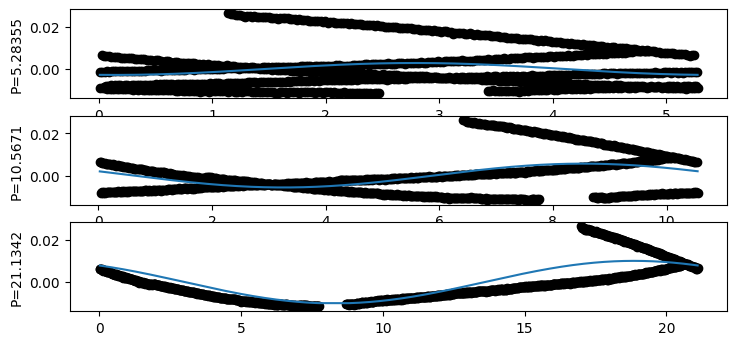

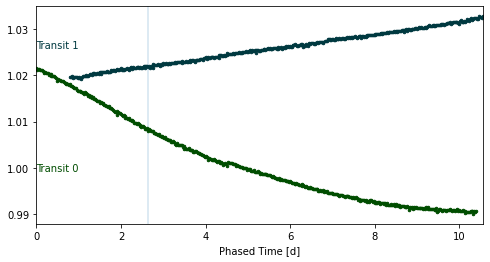

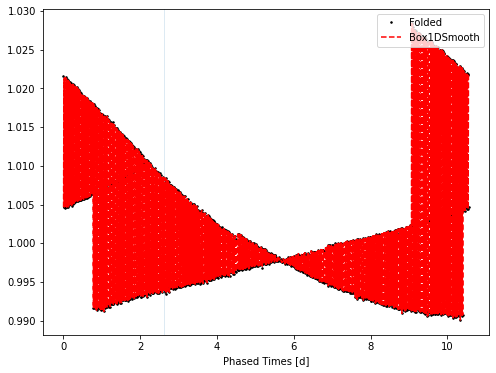

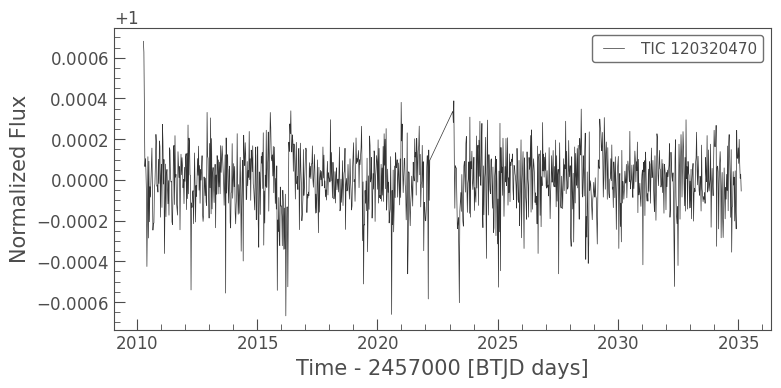

In [38]:
i = qlp_high_snr.index[0]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
mask[i] = False #There is somethign there, but clearly the detrending didnt' work.

1868
tic          TIC 120422998
pn                       3
sector                  26
period              10.554
epoch            2013.2191
depth             9481.319
dur                    1.0
snr                   17.0
disp                  FAIL
reason           -NormLPP-
match                  NaN
uniqueid       12042299826
Tmag               9.60726
Hmag                 9.108
Vmag                 9.992
contratio         0.045817
aperture         38.860428
Name: 1868, dtype: object
[0. 1. 2.]
4
[-1. -1. -1. ...  2.  2.  2.]


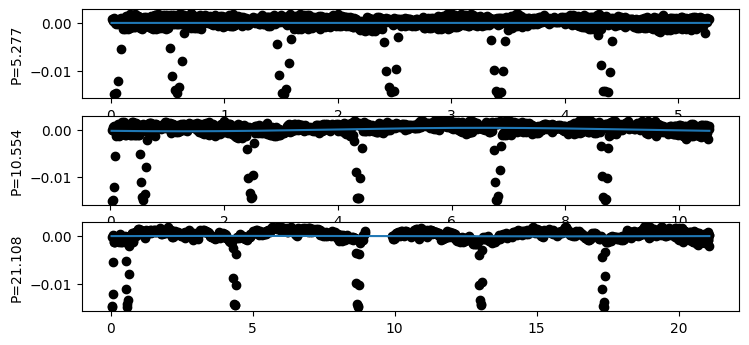

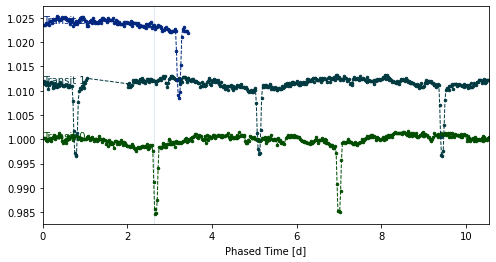

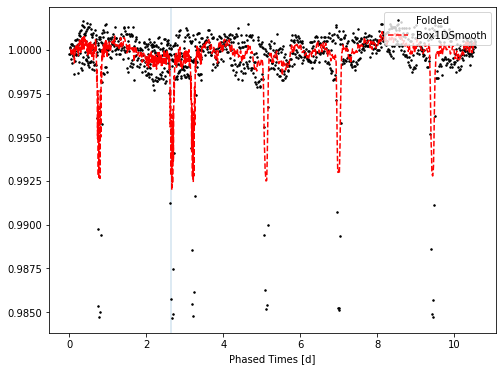

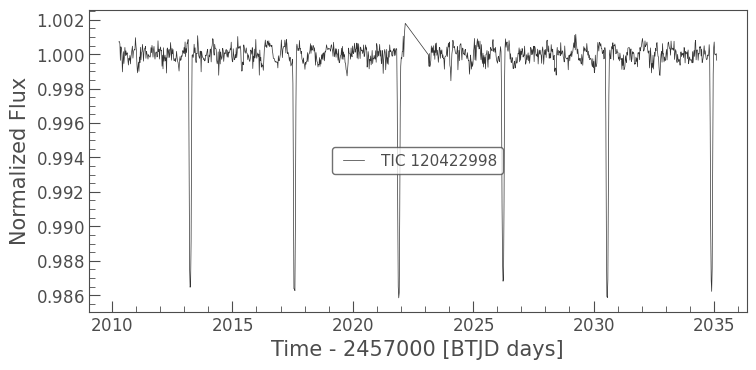

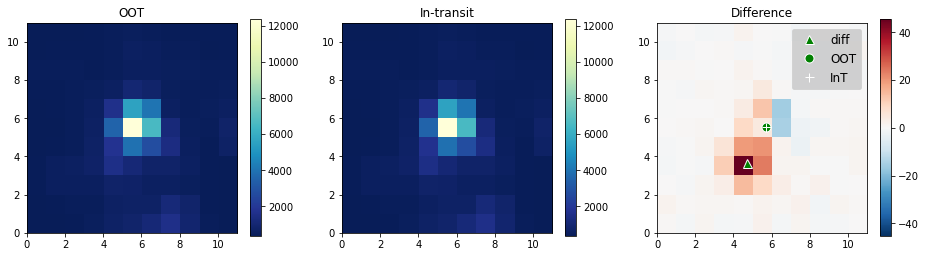

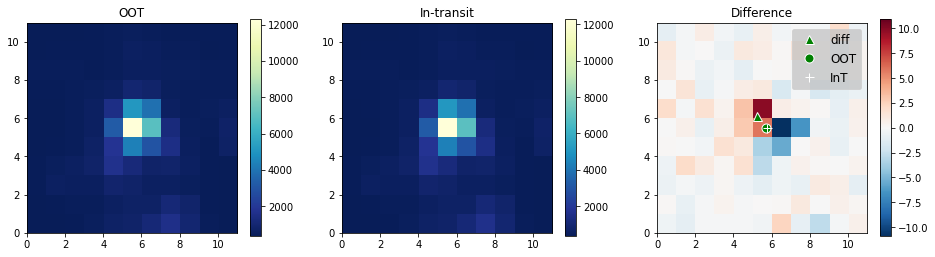

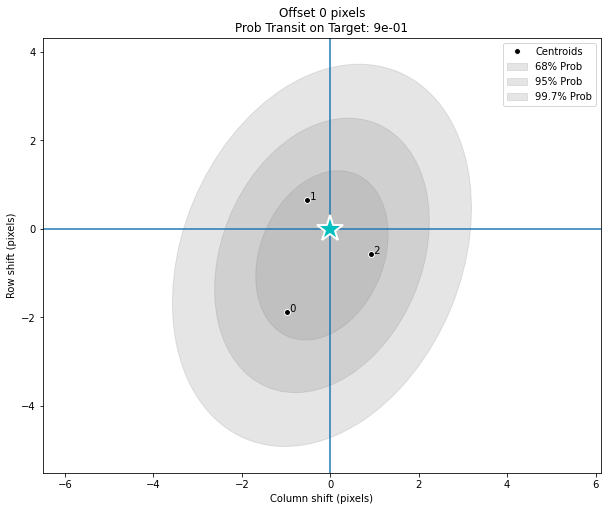

In [39]:
i = qlp_high_snr.index[1]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
mask[i] = False #K06565.01 Centroid offset

1869
tic                       TIC 120422998
pn                                    4
sector                               26
period                           8.4801
epoch                         2013.3046
depth                           7223.27
dur                                 1.0
snr                               16.33
disp                               FAIL
reason        -NormLPP--SWEETHalfPeriod
match                               NaN
uniqueid                    12042299826
Tmag                            9.60726
Hmag                              9.108
Vmag                              9.992
contratio                      0.045817
aperture                      38.860428
Name: 1869, dtype: object
[0. 1. 2.]
4
[-1. -1. -1. ...  2.  2.  2.]


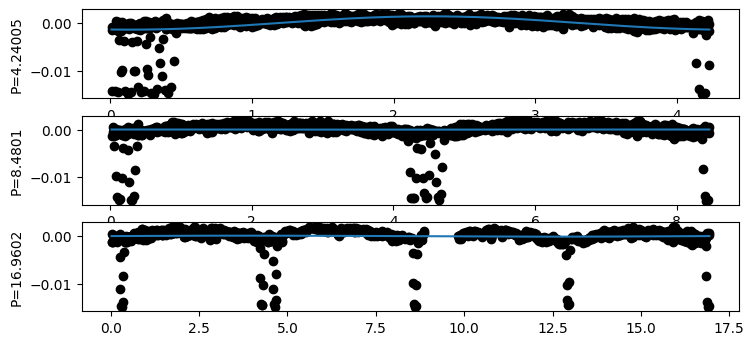

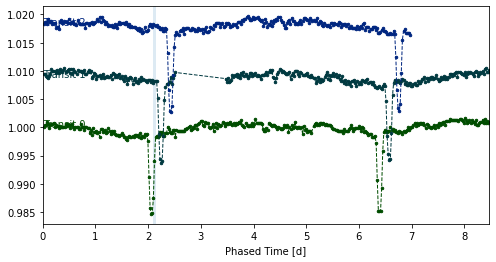

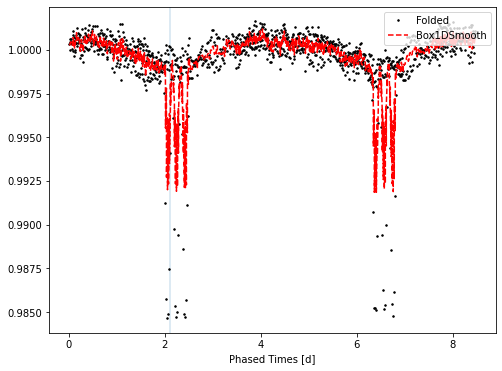

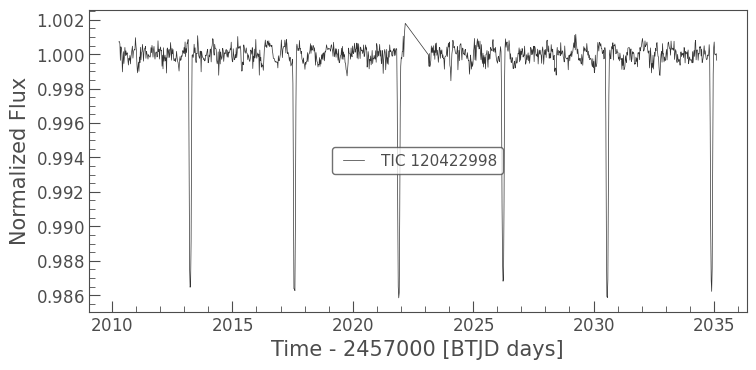

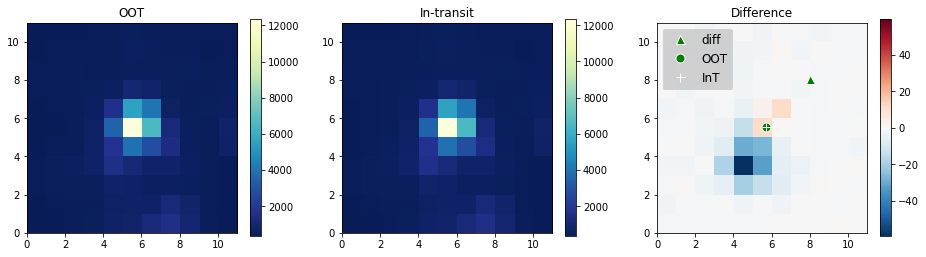

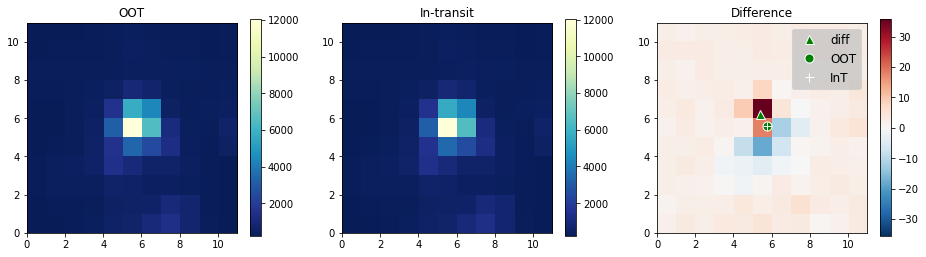

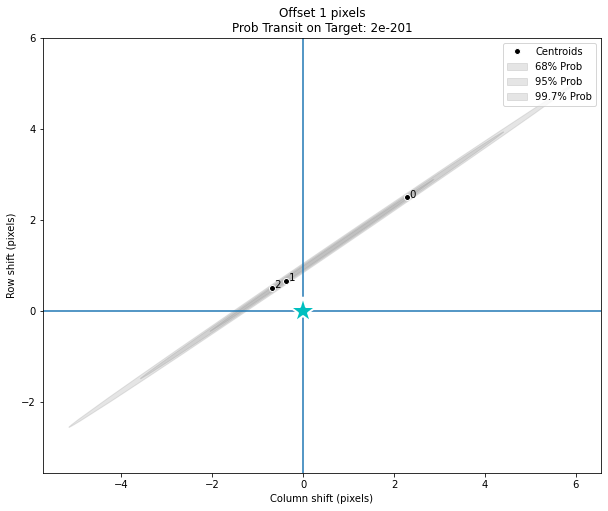

In [40]:
i = qlp_high_snr.index[2]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
mask[i] = False #K06565.01 Centroid offset

11853
tic                            TIC 123313769
pn                                         1
sector                                    26
period                               10.6168
epoch                              2020.8773
depth                              17490.805
dur                                      1.0
snr                                    19.14
disp                                    FAIL
reason        -NormLPP--PoorTransitCoverage-
match                                    NaN
uniqueid                         12331376926
Tmag                                   9.782
Hmag                                   3.111
Vmag                                  15.394
contratio                                NaN
aperture                           38.629397
Name: 11853, dtype: object
[-1.  0.  1.]
3
[-1. -1. -1. ...  1.  1.  1.]


/Users/smullally/Python_Code/exovetter-repos/official/exovetter/exovetter/centroid/covar.py:259: RuntimeWarning: invalid value encountered in true_divide
  sma_covec = sma_vec / np.linalg.norm(sma_vec) ** 2
/Users/smullally/Python_Code/exovetter-repos/official/exovetter/exovetter/centroid/covar.py:259: RuntimeWarning: invalid value encountered in true_divide
  sma_covec = sma_vec / np.linalg.norm(sma_vec) ** 2


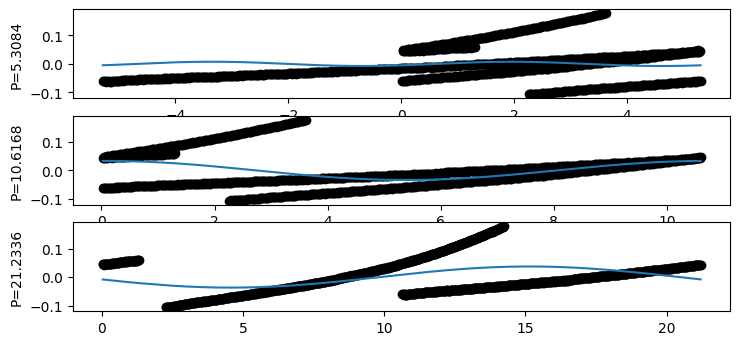

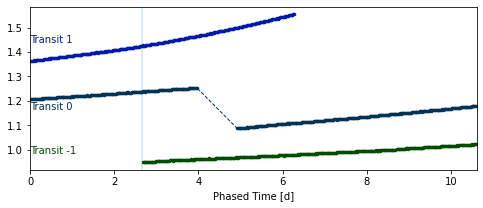

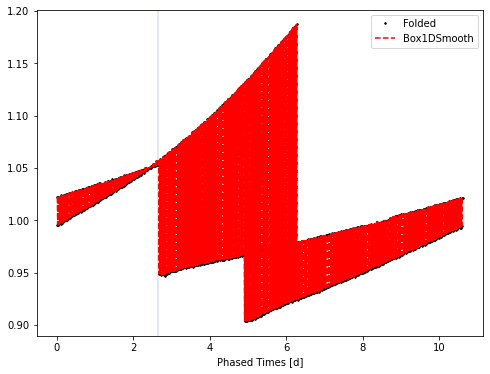

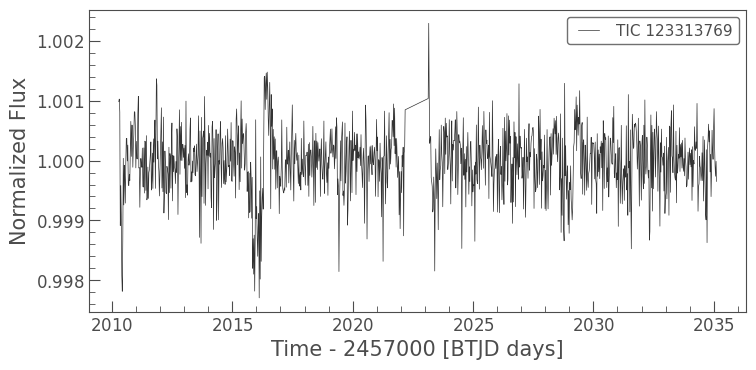

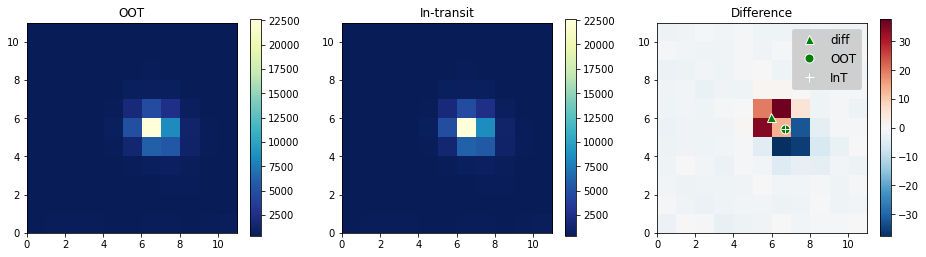

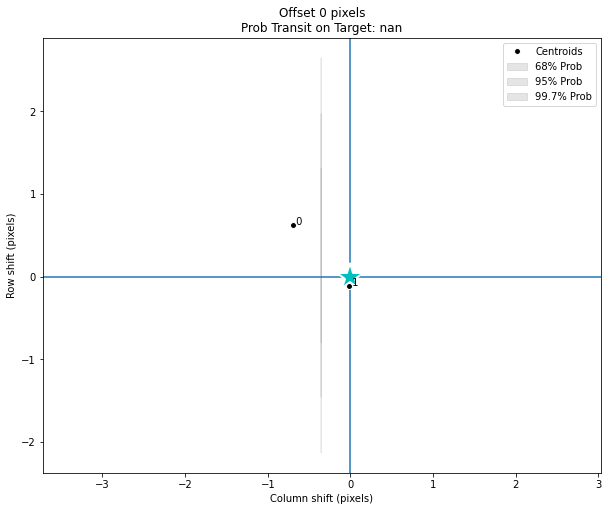

In [41]:
i = qlp_high_snr.index[3]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
mask[i] = False #poor detrending...though there could be something there.

12647
tic                            TIC 123364416
pn                                         1
sector                                    26
period                               10.6045
epoch                               2020.867
depth                               7099.109
dur                                      1.0
snr                                    15.53
disp                                    FAIL
reason        -NormLPP--PoorTransitCoverage-
match                                    NaN
uniqueid                         12336441626
Tmag                                   9.988
Hmag                                   6.958
Vmag                                   13.37
contratio                                NaN
aperture                           38.372116
Name: 12647, dtype: object
[-1.  0.  1.]
3
[-1. -1. -1. ...  1.  1.  1.]


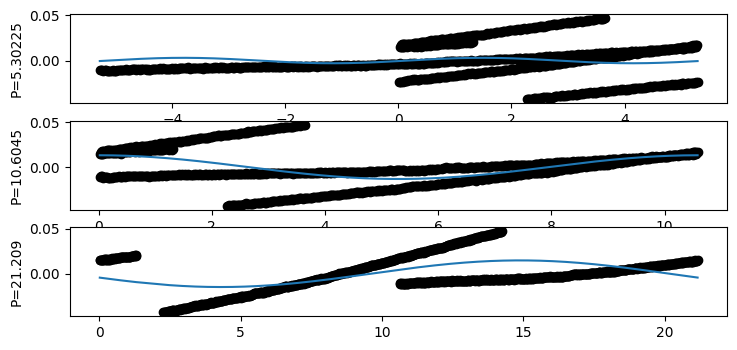

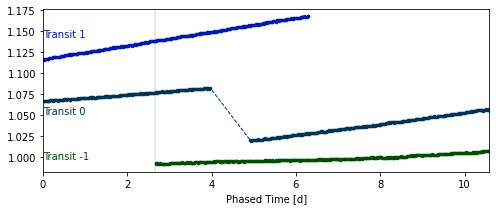

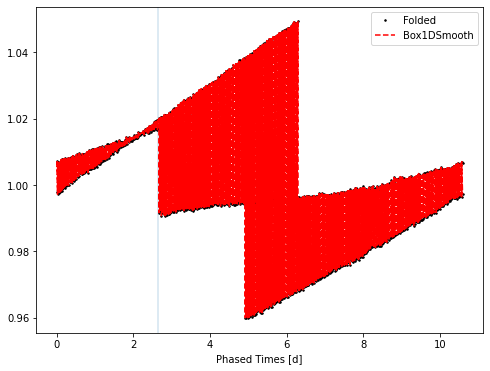

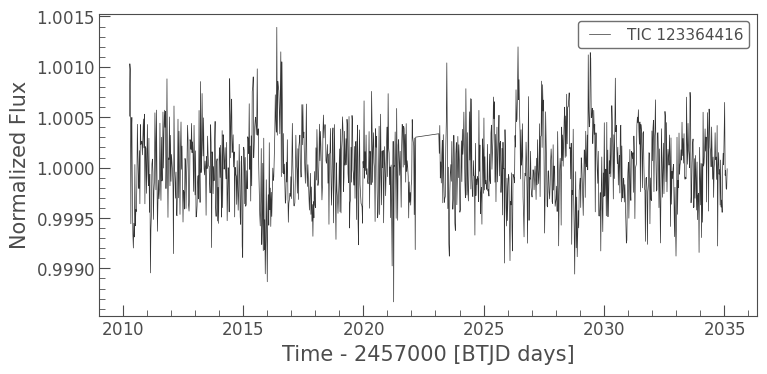

In [42]:
i = qlp_high_snr.index[4]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
#centout = cent.run(atce, atpf, plot=True)
mask[i] = False #poor detrending

24544
tic          TIC 158324584
pn                       1
sector                  26
period             10.7199
epoch            2013.6998
depth            42724.622
dur                    1.0
snr                  15.29
disp                  FAIL
reason           -NormLPP-
match                  NaN
uniqueid       15832458426
Tmag                9.9145
Hmag                 8.504
Vmag                10.832
contratio              NaN
aperture         38.463337
Name: 24544, dtype: object
[0. 1. 2.]
4
[-1. -1. -1. ...  2.  2.  2.]


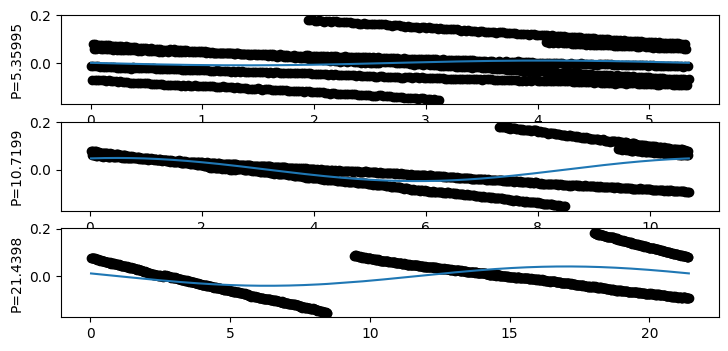

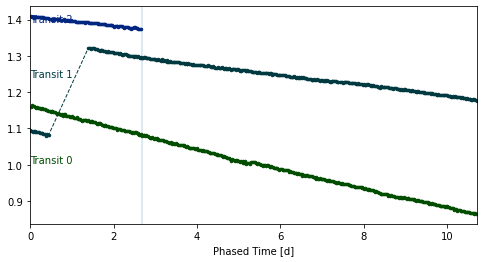

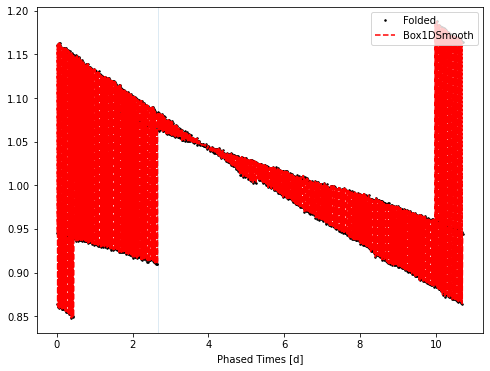

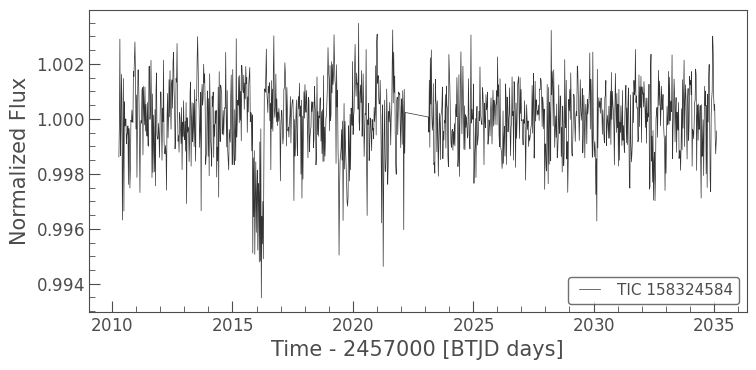

In [43]:
i = qlp_high_snr.index[5]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
#centout = cent.run(atce, atpf, plot=True)
mask[i] = False #poor detrending

31455
tic                         TIC 159097856
pn                                      3
sector                                 14
period                             8.6692
epoch                           1690.1951
depth                           28784.399
dur                                   1.0
snr                                 19.48
disp                                 FAIL
reason        -NormLPP--SWEETTwicePeriod-
match                                 NaN
uniqueid                      15909785614
Tmag                              12.2834
Hmag                               11.533
Vmag                               12.759
contratio                        0.108655
aperture                        28.749824
Name: 31455, dtype: object
[0. 1. 2.]
4
[-1. -1. -1. ...  2.  2.  2.]


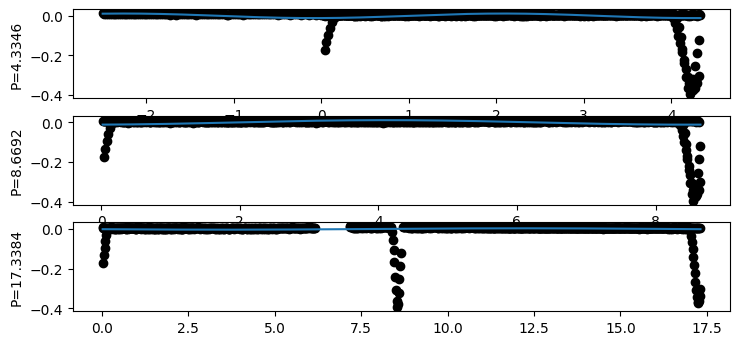

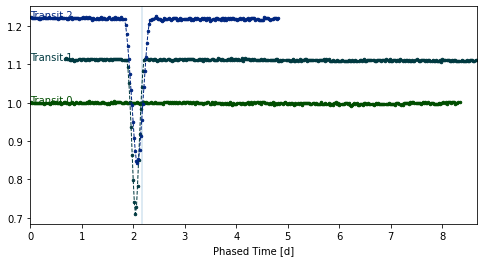

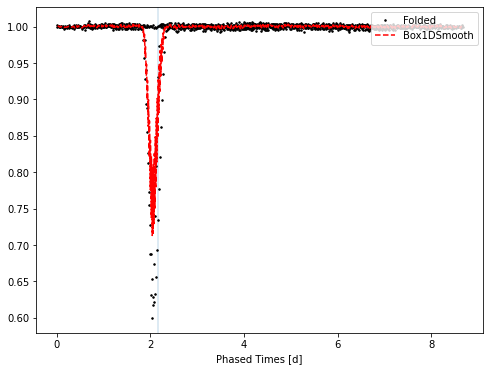

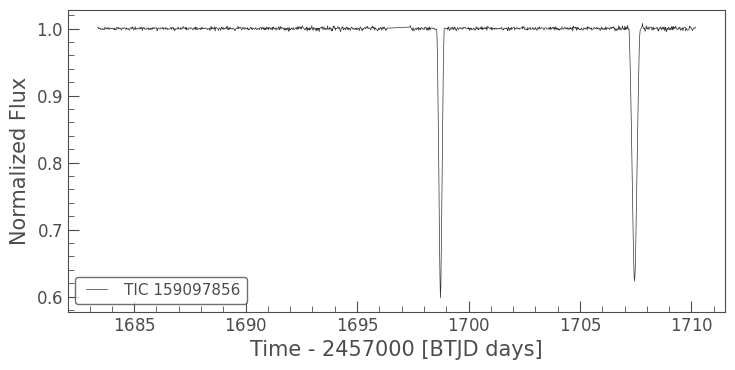

In [44]:
i = qlp_high_snr.index[6]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
#centout = cent.run(atce, atpf, plot=True)
mask[i] = False #Known EB from Kepler 8553907

32243
tic                            TIC 159180123
pn                                         1
sector                                    14
period                                8.6586
epoch                              1687.9221
depth                              48804.613
dur                                      1.0
snr                                    18.64
disp                                    FAIL
reason        -NormLPP--PoorTransitCoverage-
match                                    NaN
uniqueid                         15918012314
Tmag                                  11.754
Hmag                                  11.129
Vmag                                  12.344
contratio                           0.756855
aperture                           33.273257
Name: 32243, dtype: object
[0. 2.]
4
[-1. -1. -1. ...  2.  2.  2.]


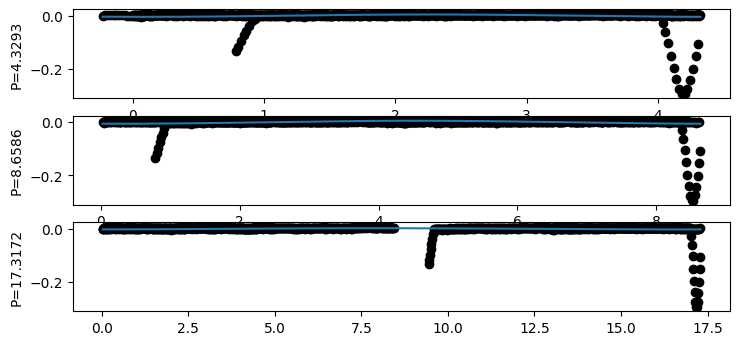

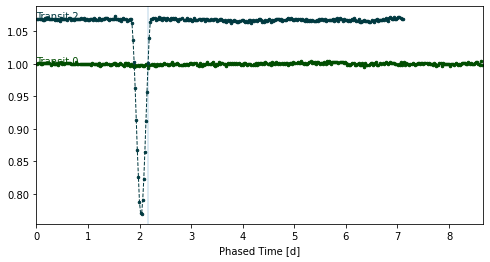

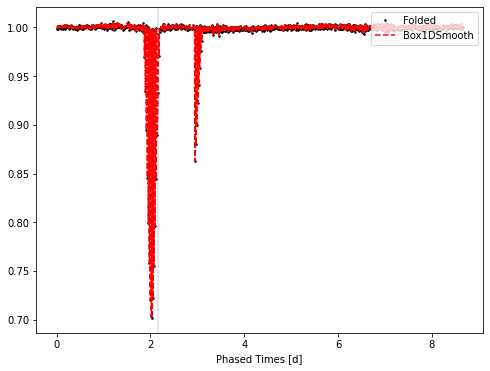

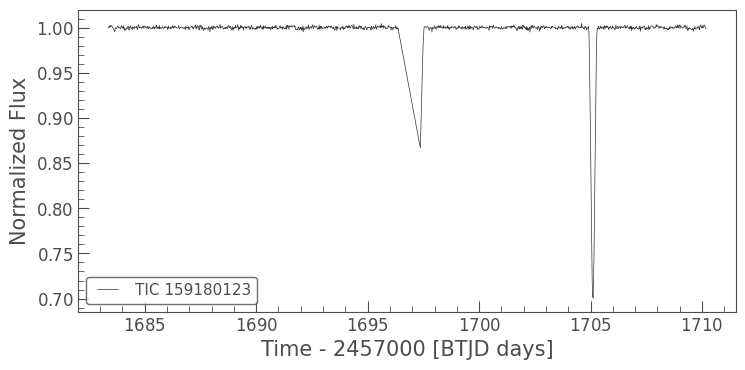

In [45]:
i = qlp_high_snr.index[7]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
#centout = cent.run(atce, atpf, plot=True)
mask[i] = False #PC K06903.01

34282
tic          TIC 159573320
pn                       1
sector                  14
period             10.8766
epoch            1687.4658
depth             6943.255
dur                    4.0
snr                  19.42
disp                  FAIL
reason           -NormLPP-
match                  NaN
uniqueid       15957332014
Tmag               9.22374
Hmag                 7.873
Vmag                10.014
contratio              NaN
aperture          39.47777
Name: 34282, dtype: object
[0. 1. 2.]
4
[-1. -1. -1. ...  2.  2.  2.]


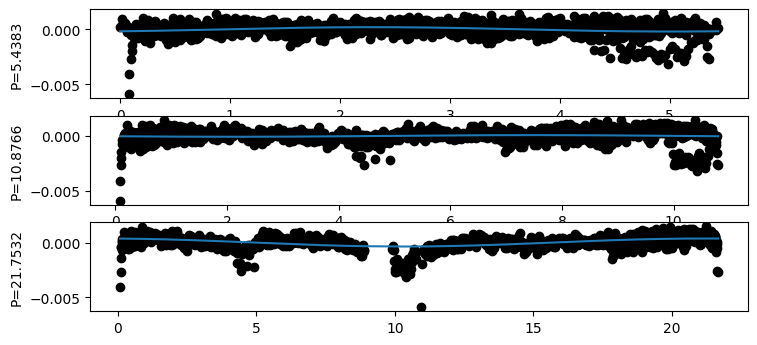

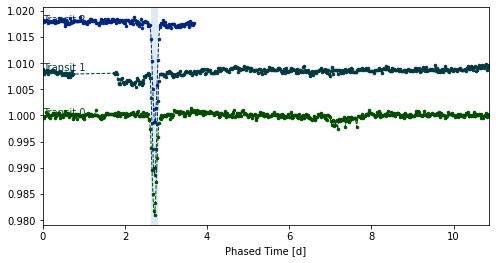

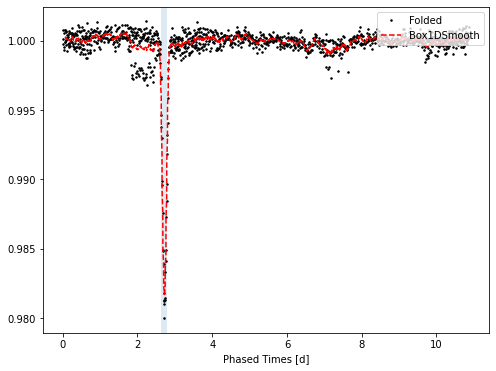

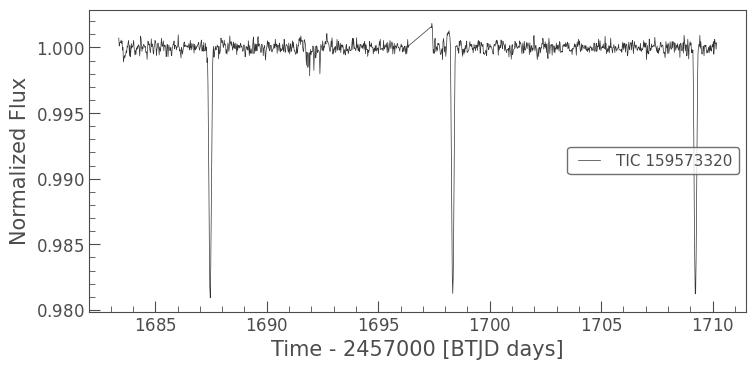

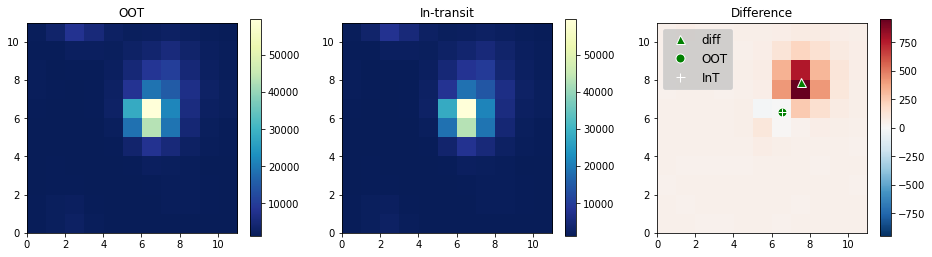

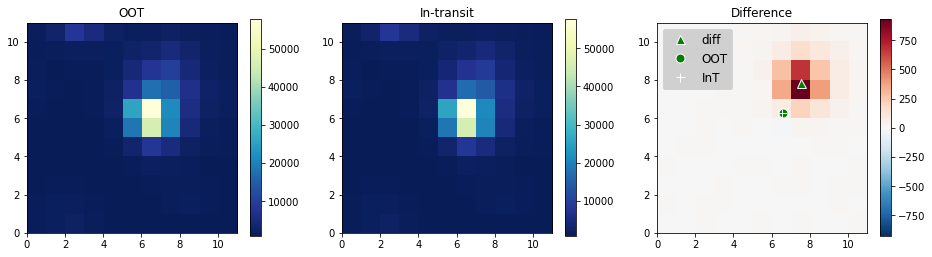

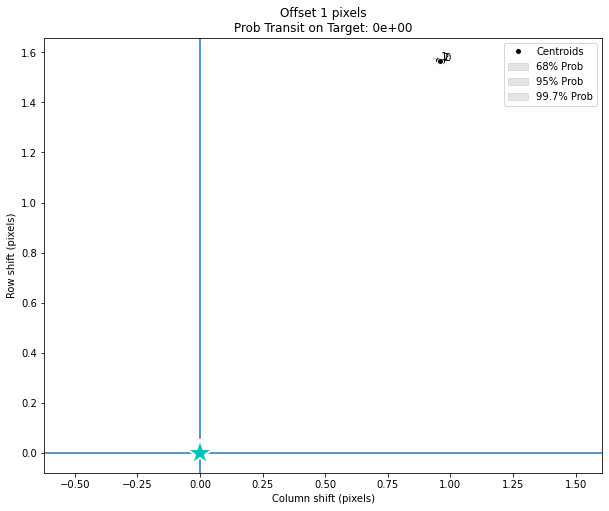

In [46]:
i = qlp_high_snr.index[8]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
mask[i] = False #CO 6859813 num:4;CO K03321.01

### Potentially interesting Target. Not a known Kepler or TESS EB or KOI


38566
tic                TIC 164658643
pn                             1
sector                        26
period                    8.7737
epoch                  2017.6539
depth                  29836.981
dur                          4.0
snr                        15.14
disp                        FAIL
reason        -SWEETTwicePeriod-
match                        NaN
uniqueid             16465864326
Tmag                     12.0281
Hmag                      11.194
Vmag                      12.545
contratio               0.415578
aperture                31.24947
Name: 38566, dtype: object
[0. 1. 2.]
4
[-1. -1. -1. ...  2.  2.  2.]


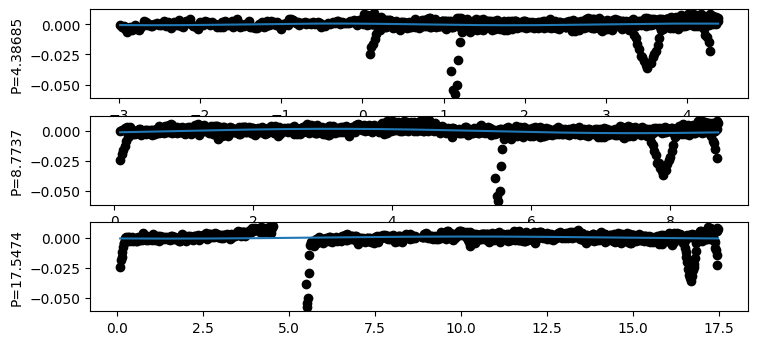

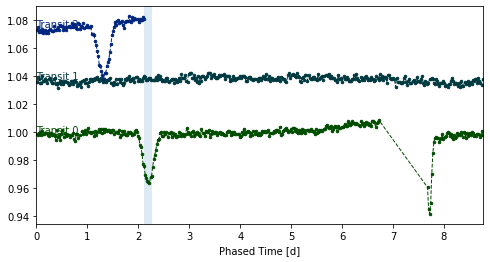

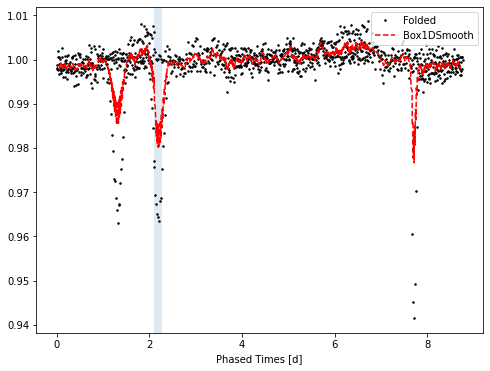

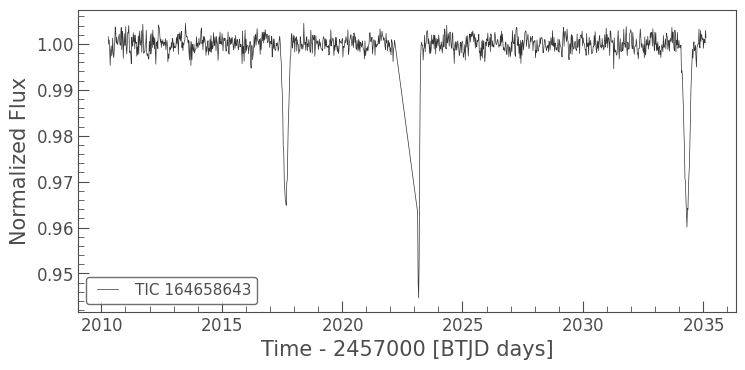

In [48]:
i = qlp_high_snr.index[9]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
#centout = cent.run(atce, atpf, plot=True)
mask[i] = False  #Clearly a transit

40903
tic          TIC 164882231
pn                       2
sector                  26
period             10.4597
epoch              2014.45
depth             8480.339
dur                    1.0
snr                  16.54
disp                  FAIL
reason           -NormLPP-
match                  NaN
uniqueid       16488223126
Tmag                9.2501
Hmag                 6.963
Vmag                11.331
contratio              NaN
aperture         39.428444
Name: 40903, dtype: object
[0. 1.]
4
[-1. -1. -1. ...  2.  2.  2.]


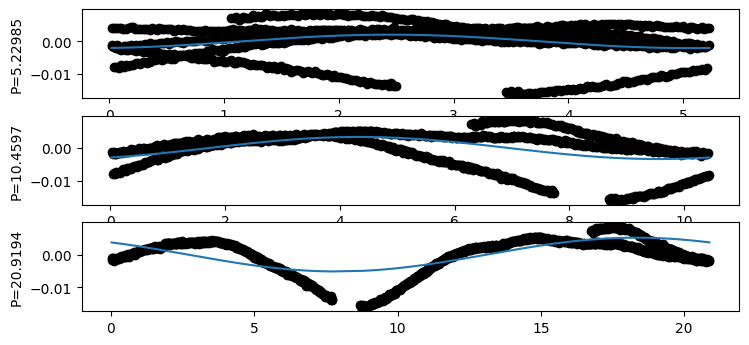

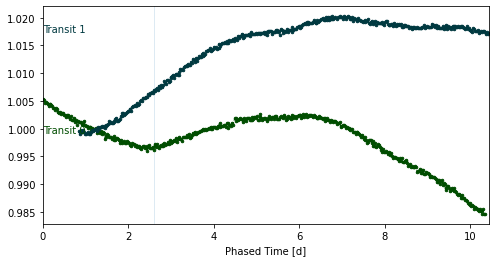

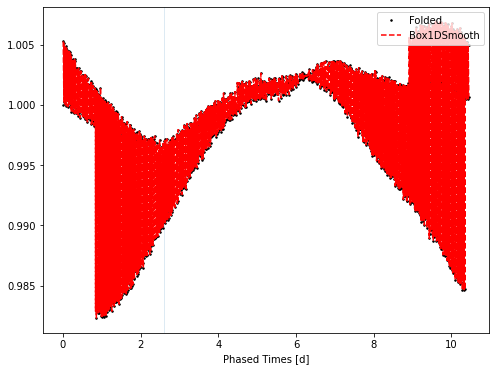

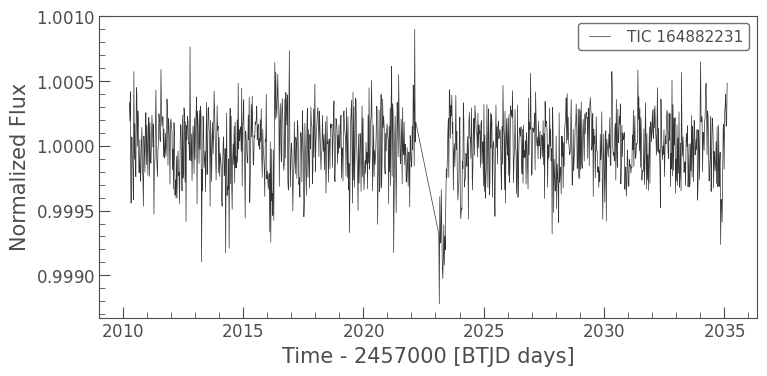

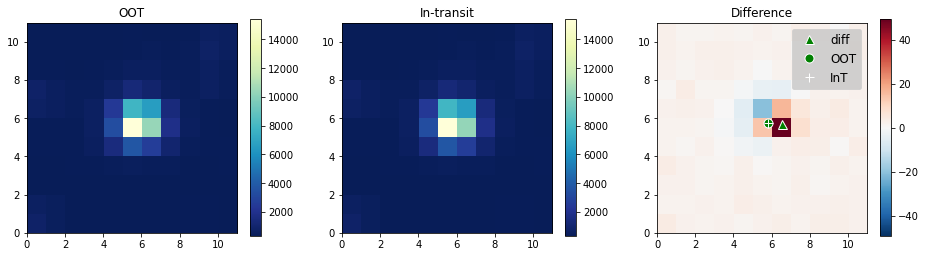

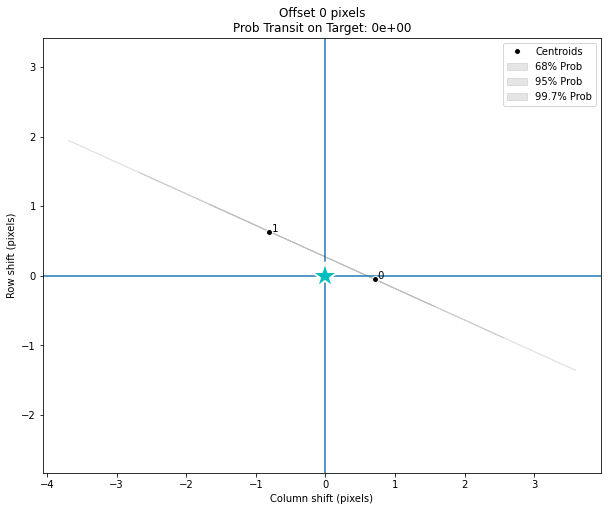

In [49]:
i = qlp_high_snr.index[10]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
mask[i] = False #poor detrending

44686
tic          TIC 170253873
pn                       1
sector                  14
period              6.1937
epoch            1684.8403
depth             84056.46
dur                    4.0
snr                  19.24
disp                  PASS
reason                    
match                  NaN
uniqueid       17025387314
Tmag               12.8771
Hmag                11.846
Vmag                13.503
contratio         0.181882
aperture         18.785324
Name: 44686, dtype: object
[0. 1. 2. 3. 4.]
5
[0. 0. 0. ... 4. 4. 4.]


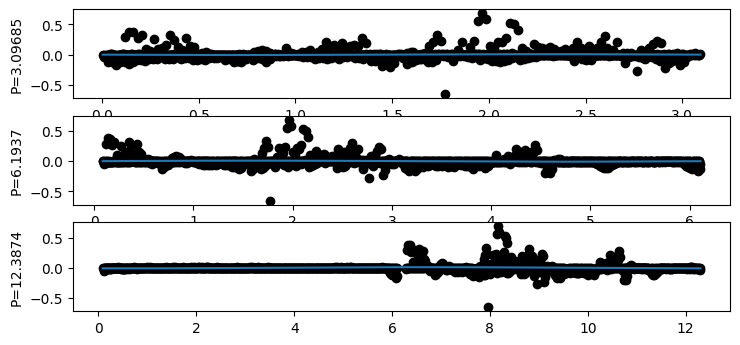

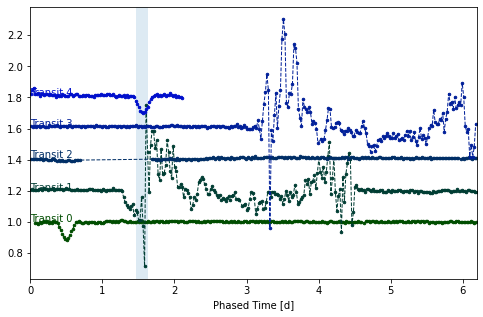

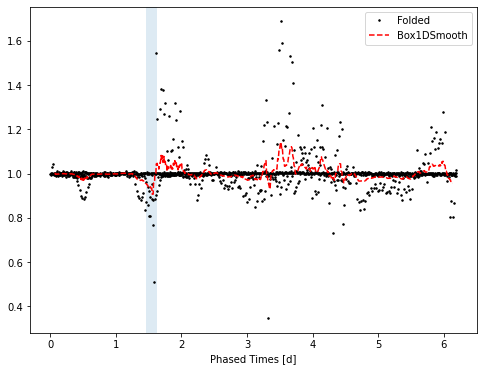

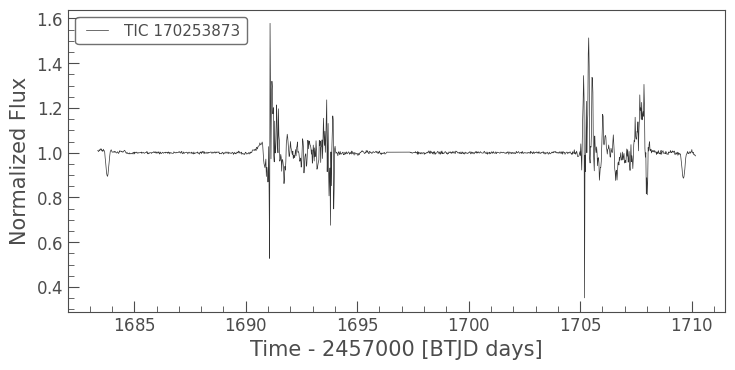

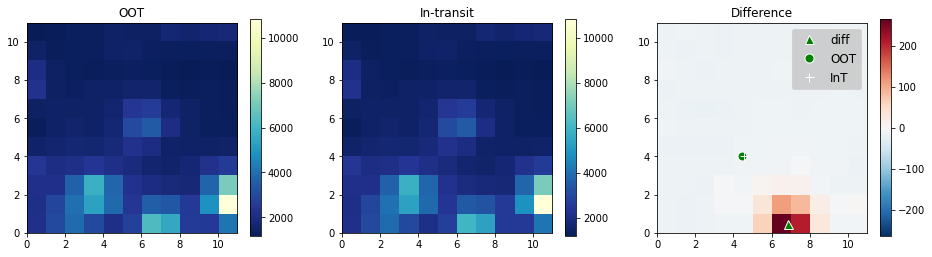

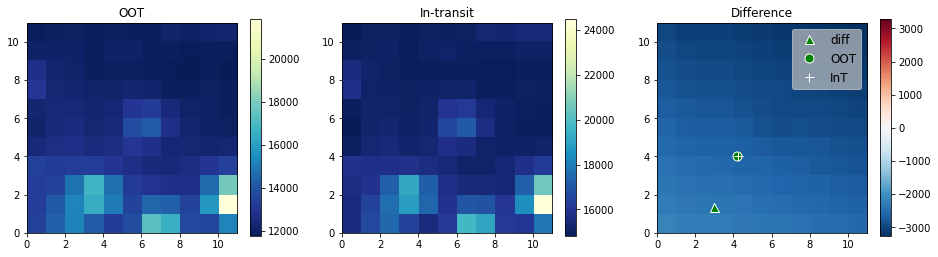

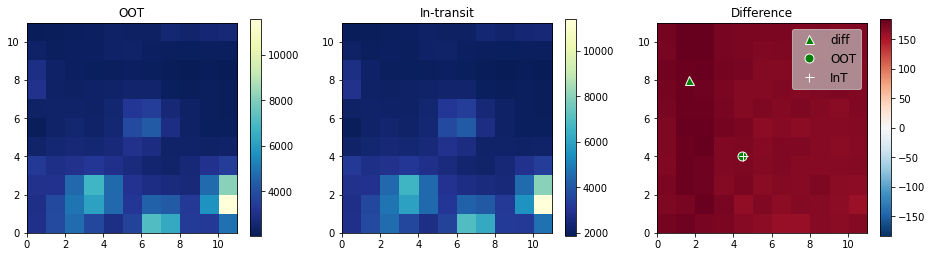

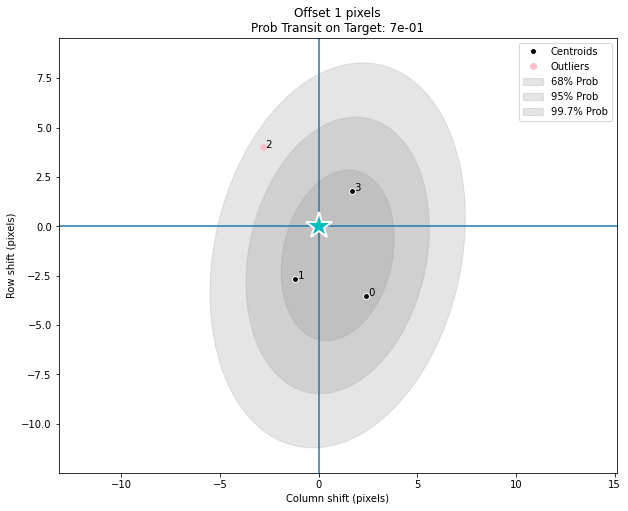

In [50]:
i = qlp_high_snr.index[11]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
mask[i] = False #K06669.01 #Known Kepler EB of 25 days, looks like a centroid offset

49180
tic                                              TIC 184008814
pn                                                           3
sector                                                      15
period                                                  6.1702
epoch                                                1713.2098
depth                                               108715.548
dur                                                        4.0
snr                                                      18.23
disp                                                      FAIL
reason        -SWEETHalfPeriod-SWEETAtPeriod-SWEETTwicePeriod-
match                                                      NaN
uniqueid                                           18400881415
Tmag                                                   12.8241
Hmag                                                    11.865
Vmag                                                    13.403
contratio                                        

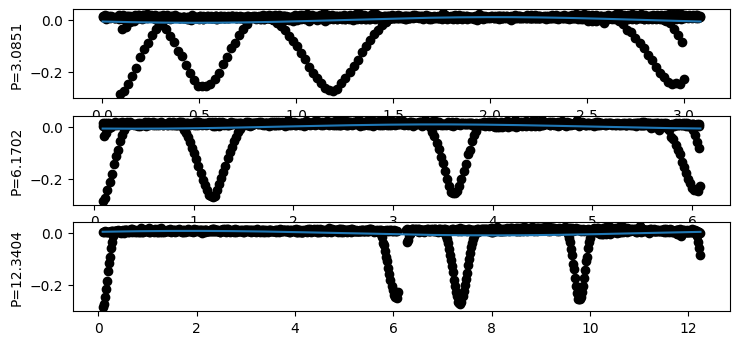

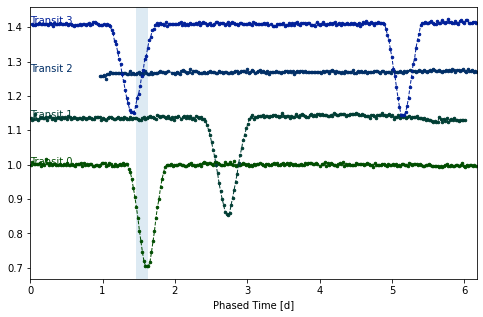

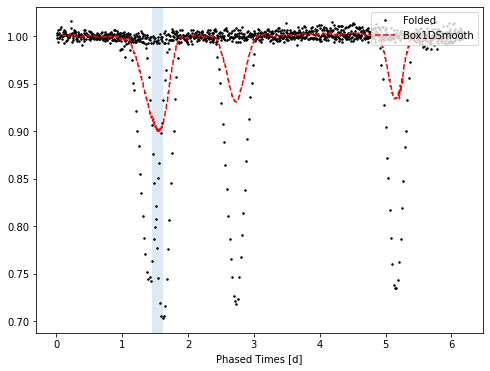

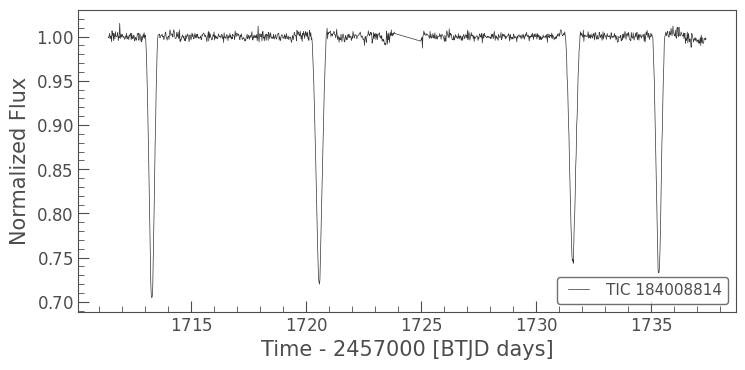

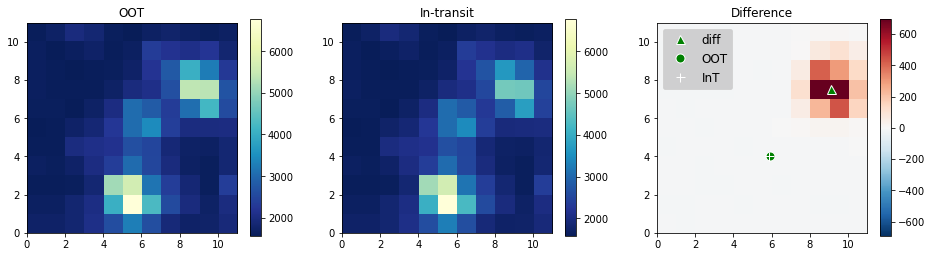

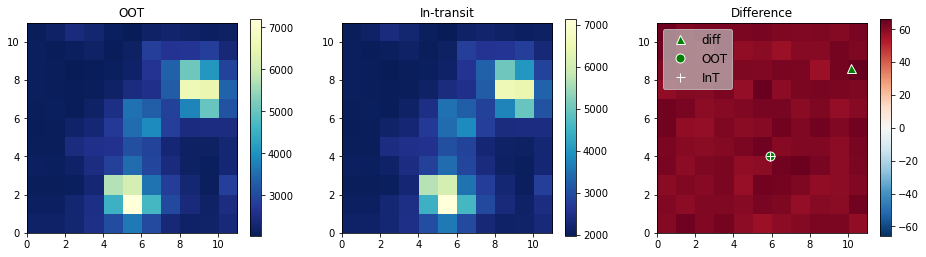

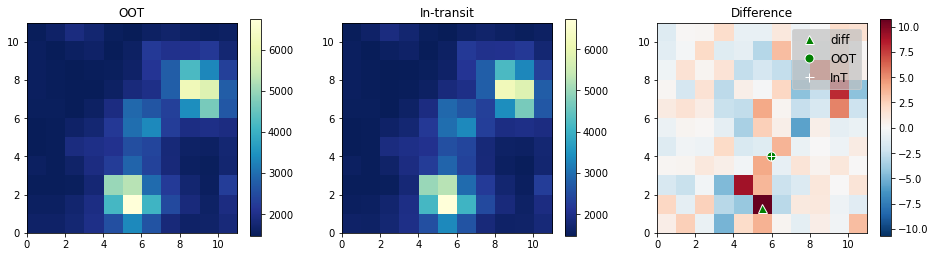

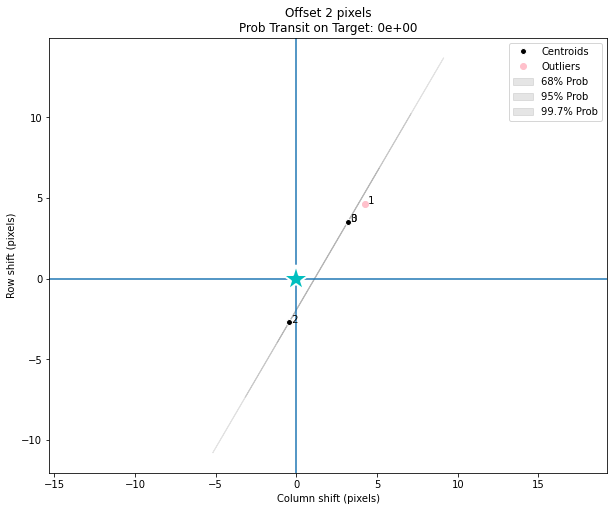

In [51]:
i = qlp_high_snr.index[12]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
mask[i-2:i+1] = [False,False,False]  #CO EB at 11day period KIC 5632781 CO K06609.01 num:4;CO 5632781

52512
tic                                     TIC 185109901
pn                                                  1
sector                                             15
period                                         4.3236
epoch                                       1712.3304
depth                                       43349.705
dur                                               4.0
snr                                             17.08
disp                                             FAIL
reason        -NormLPP--SWEETHalfPeriod-SWEETAtPeriod
match                                             NaN
uniqueid                                  18510990115
Tmag                                          12.1095
Hmag                                           10.807
Vmag                                           12.899
contratio                                    0.244923
aperture                                    30.526225
Name: 52512, dtype: object
[0. 1. 2. 3. 4.]
5
[0. 0. 0. ... 6. 6. 6.]


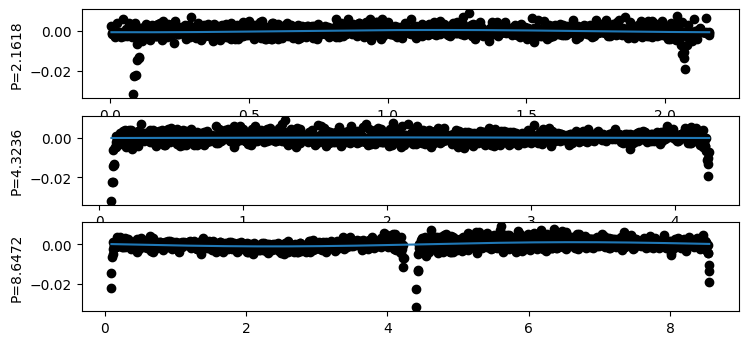

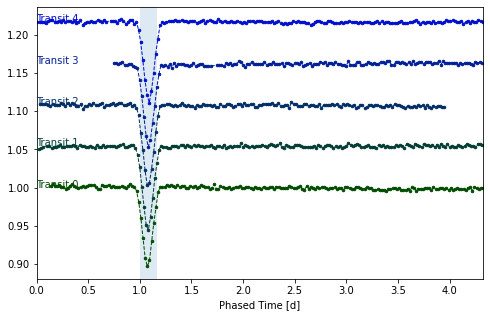

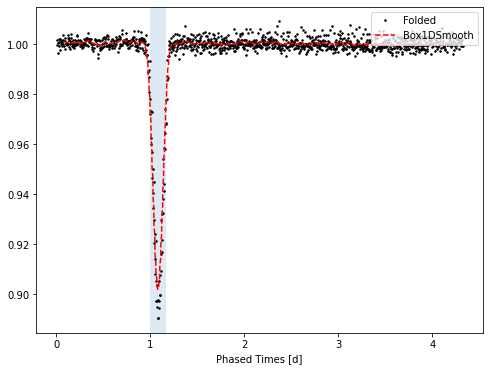

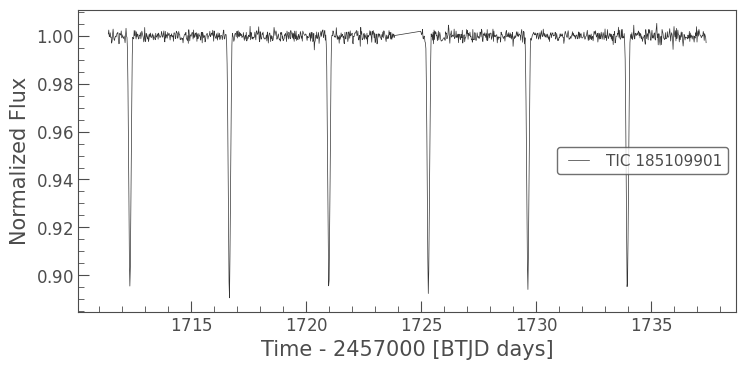

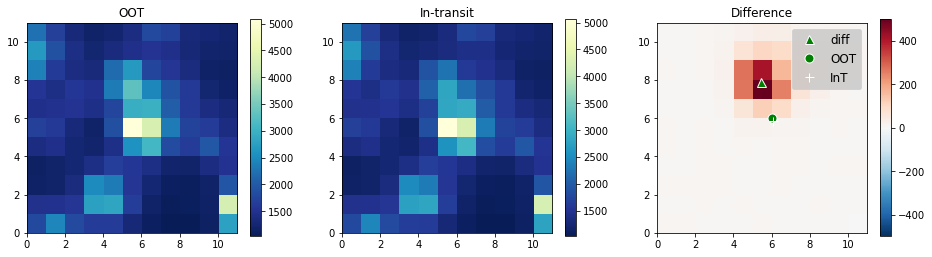

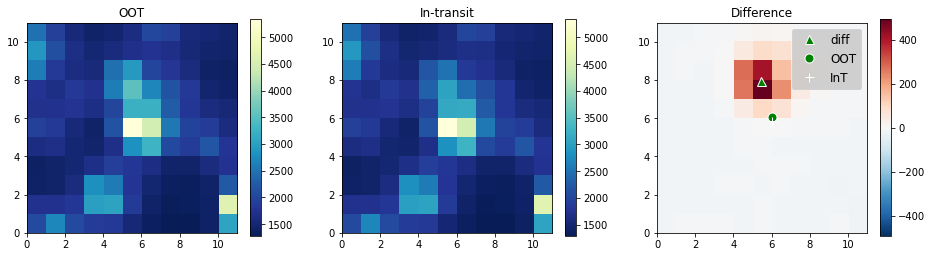

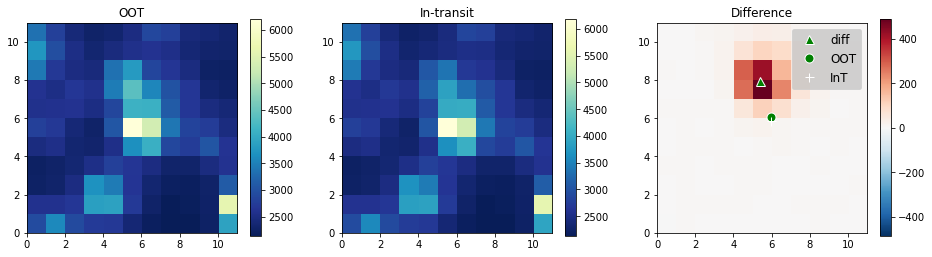

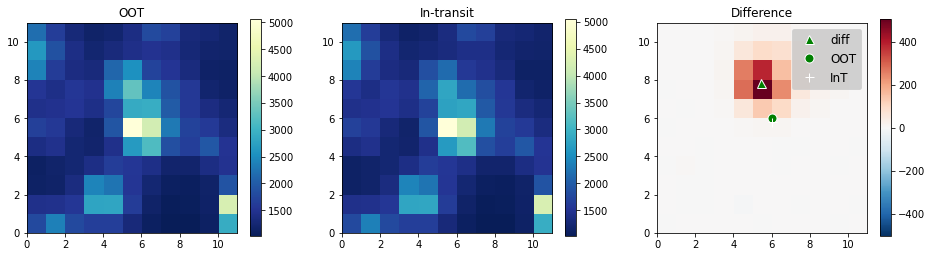

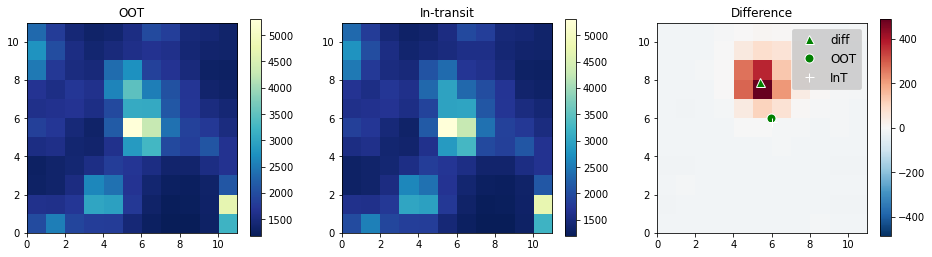

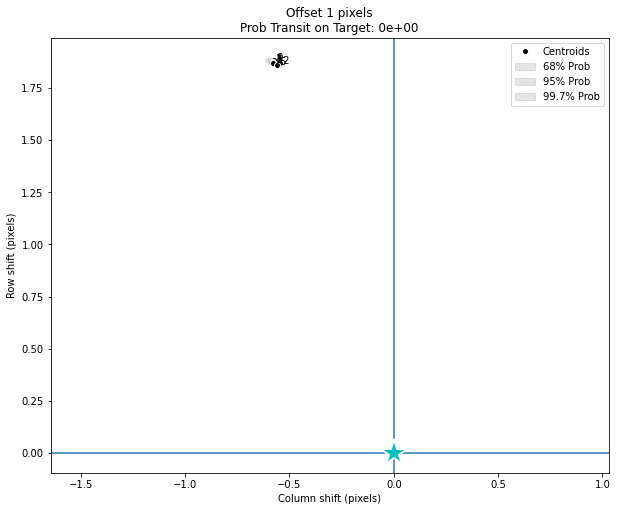

In [52]:
i = qlp_high_snr.index[13]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
mask[i] = False #CO K06183.01 num:7;CO 8590780

57596


/Users/smullally/miniconda3/envs/exovetter/lib/python3.7/site-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,


tic                                               TIC 26542657
pn                                                           3
sector                                                      14
period                                                  9.7333
epoch                                                1690.8617
depth                                                 8834.613
dur                                                        1.0
snr                                                      21.66
disp                                                      FAIL
reason        -NormLPP--PoorTransitCoverage--SWEETHalfPerio...
match                                                      NaN
uniqueid                                            2654265714
Tmag                                                     8.626
Hmag                                                     7.978
Vmag                                                     9.267
contratio                                              

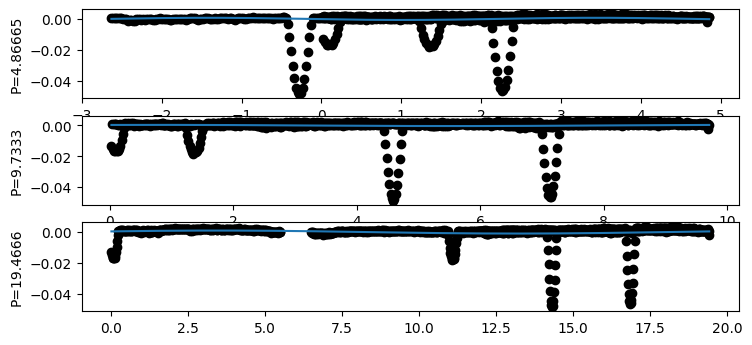

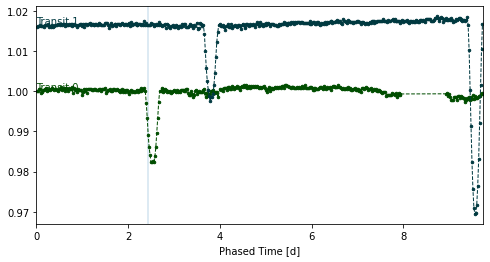

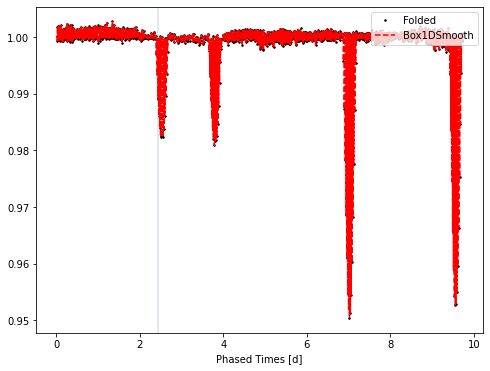

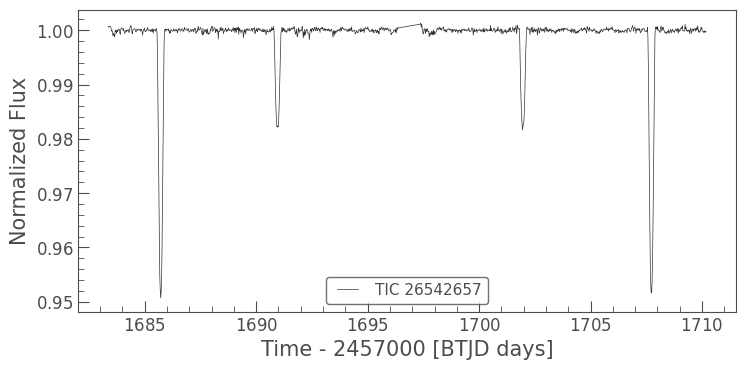

In [54]:
i = qlp_high_snr.index[14]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
#centout = cent.run(atce, atpf, plot=True)
mask[i] = False #CO CO K06730.01 num:1

86049
tic                                              TIC 274118370
pn                                                           2
sector                                                      15
period                                                 10.6298
epoch                                                1718.0888
depth                                                41692.429
dur                                                        8.0
snr                                                      17.11
disp                                                      FAIL
reason        -NormLPP--SWEETHalfPeriod-SWEETAtPeriod-SWEET...
match                                                      NaN
uniqueid                                           27411837015
Tmag                                                   12.1971
Hmag                                                    10.875
Vmag                                                    12.587
contratio                                        

/Users/smullally/Python_Code/exovetter-repos/official/exovetter/exovetter/centroid/covar.py:211: RuntimeWarning: invalid value encountered in sqrt
  sma_vec = eigenVecs[:, 0] * np.sqrt(eigenVals[0])
/Users/smullally/Python_Code/exovetter-repos/official/exovetter/exovetter/centroid/covar.py:211: RuntimeWarning: invalid value encountered in sqrt
  sma_vec = eigenVecs[:, 0] * np.sqrt(eigenVals[0])


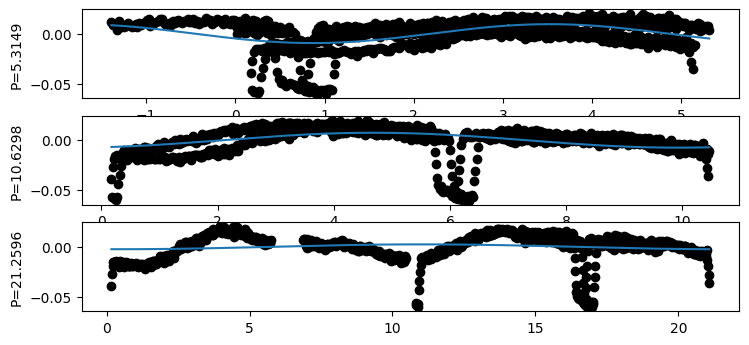

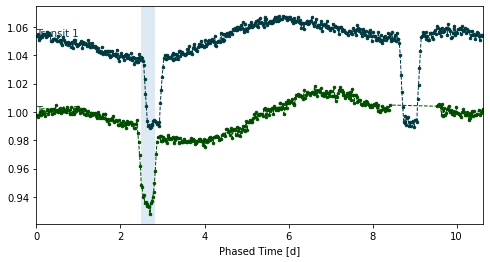

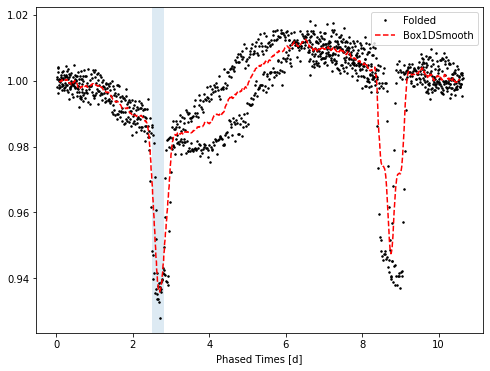

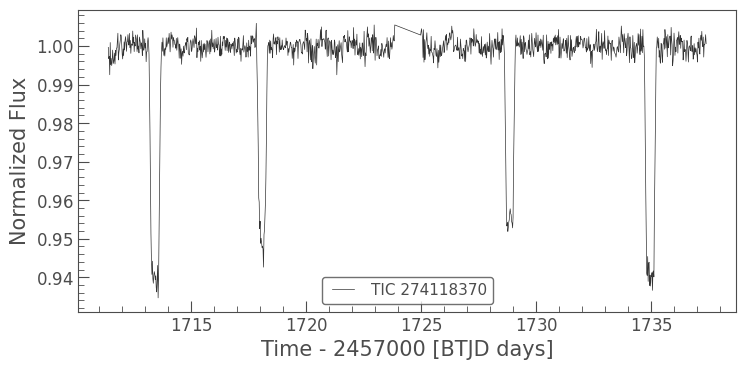

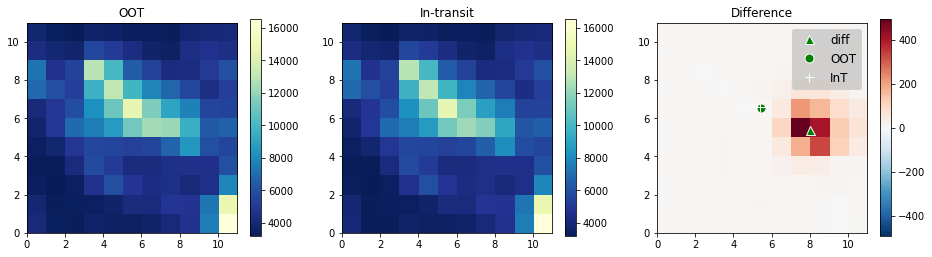

ValueError: need at least one array to concatenate

<Figure size 720x576 with 1 Axes>

In [55]:
i = qlp_high_snr.index[15]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
mask[i-2:i+1] = [False,False,False] #Known EB

90383


/Users/smullally/miniconda3/envs/exovetter/lib/python3.7/site-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,


tic                             TIC 27845677
pn                                         3
sector                                    14
period                               10.4091
epoch                              1685.9844
depth                               16453.27
dur                                      1.0
snr                                    15.43
disp                                    FAIL
reason        -NormLPP--PoorTransitCoverage-
match                                    NaN
uniqueid                          2784567714
Tmag                                  11.198
Hmag                                   10.76
Vmag                                  11.499
contratio                                NaN
aperture                           35.945982
Name: 90383, dtype: object
[0. 1. 2.]
4
[-1.  0.  0. ...  2.  2.  2.]


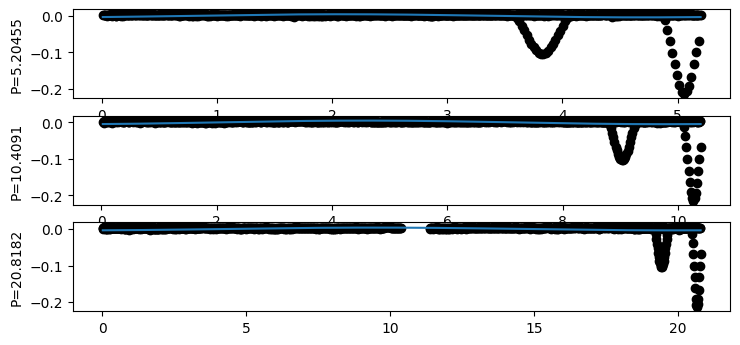

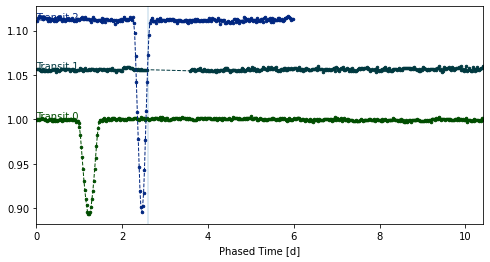

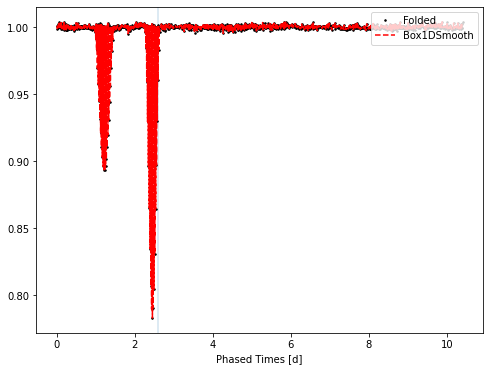

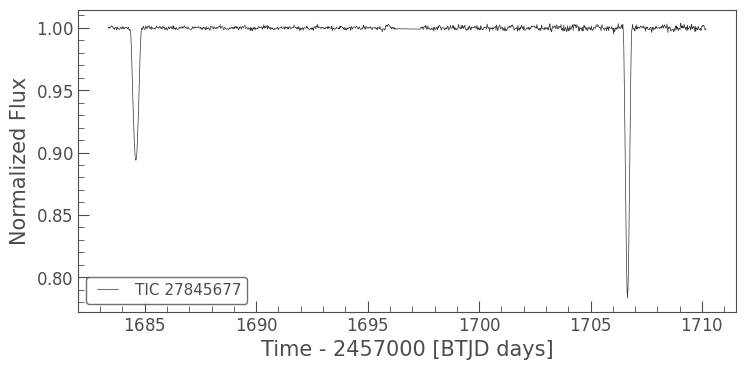

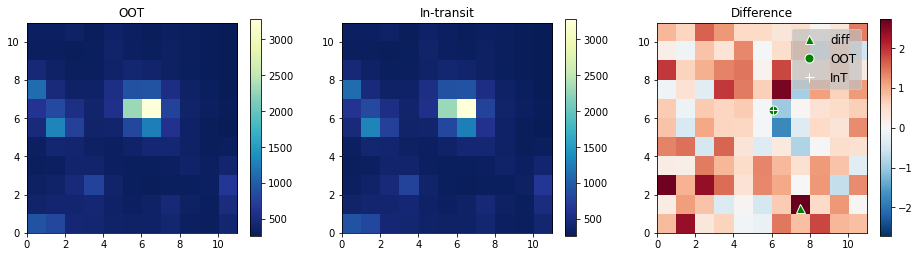

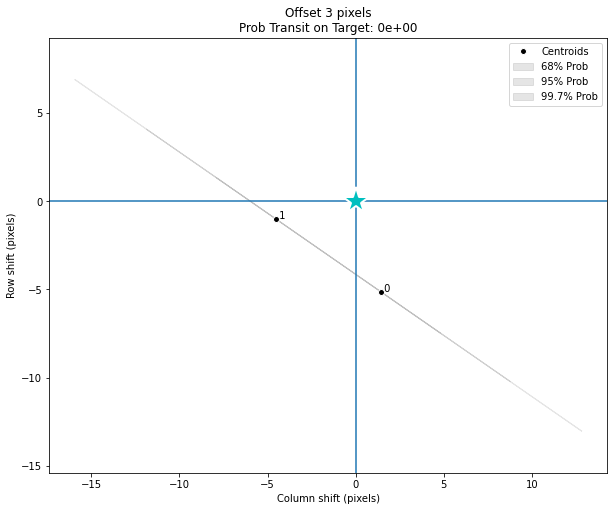

In [56]:
i = qlp_high_snr.index[16]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
#No reason to fail it, though it is on a target

96257
tic                            TIC 299096335
pn                                         2
sector                                    14
period                                7.2919
epoch                              1689.2182
depth                             107019.068
dur                                      1.0
snr                                     22.9
disp                                    FAIL
reason        -NormLPP--PoorTransitCoverage-
match                                    NaN
uniqueid                         29909633514
Tmag                                 12.8497
Hmag                                  11.555
Vmag                                  13.683
contratio                                NaN
aperture                           19.468554
Name: 96257, dtype: object
[0. 2.]
5
[-1. -1. -1. ...  3.  3.  3.]


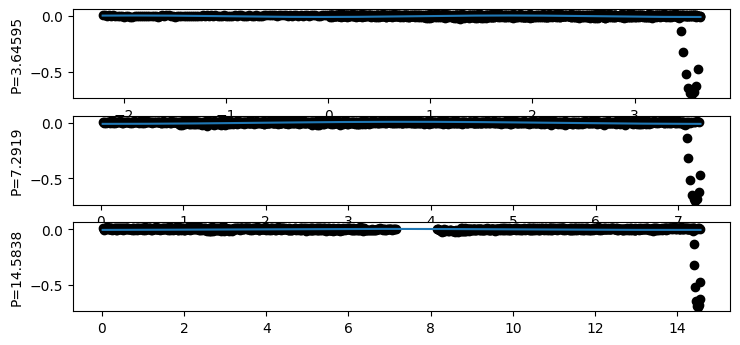

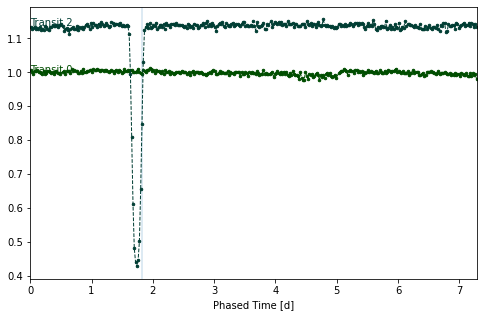

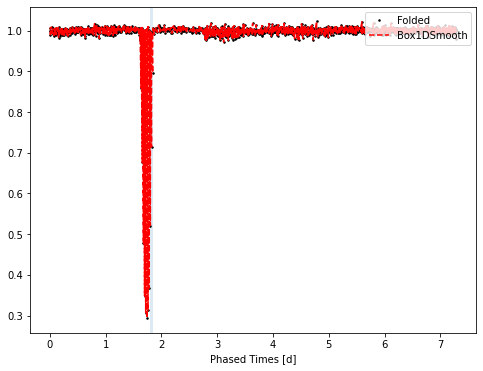

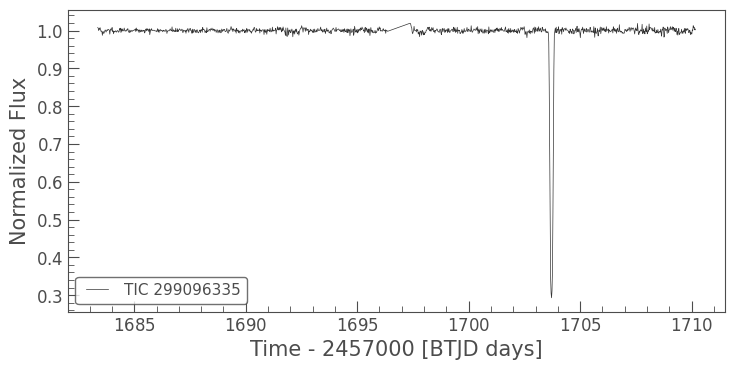

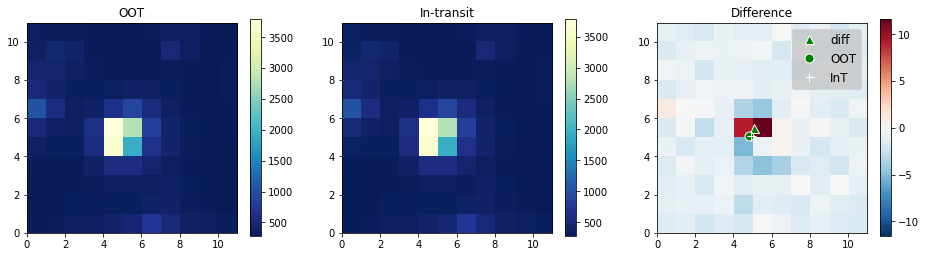

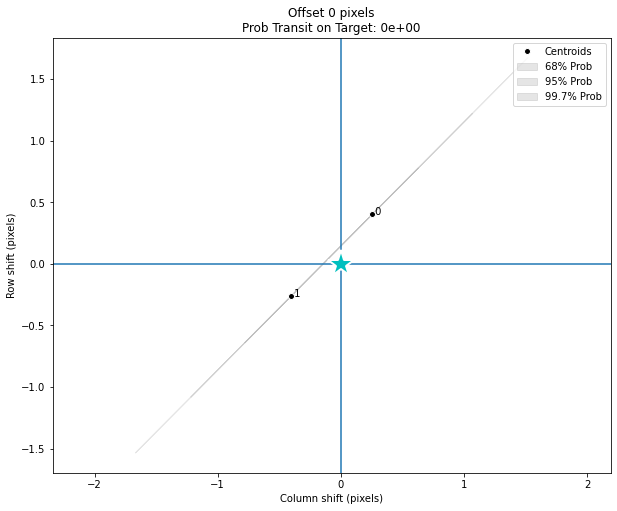

In [57]:
i = qlp_high_snr.index[17]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)

96266
tic                            TIC 299096355
pn                                         1
sector                                    26
period                                9.6266
epoch                              2016.3035
depth                              20927.799
dur                                      1.0
snr                                    16.75
disp                                    FAIL
reason        -NormLPP--PoorTransitCoverage-
match                                    NaN
uniqueid                         29909635526
Tmag                                 10.9438
Hmag                                   9.137
Vmag                                  12.144
contratio                           0.169398
aperture                           36.723424
Name: 96266, dtype: object
[0. 1.]
4
[-1. -1. -1. ...  2.  2.  2.]


/Users/smullally/Python_Code/exovetter-repos/official/exovetter/exovetter/centroid/covar.py:211: RuntimeWarning: invalid value encountered in sqrt
  sma_vec = eigenVecs[:, 0] * np.sqrt(eigenVals[0])
/Users/smullally/Python_Code/exovetter-repos/official/exovetter/exovetter/centroid/covar.py:211: RuntimeWarning: invalid value encountered in sqrt
  sma_vec = eigenVecs[:, 0] * np.sqrt(eigenVals[0])


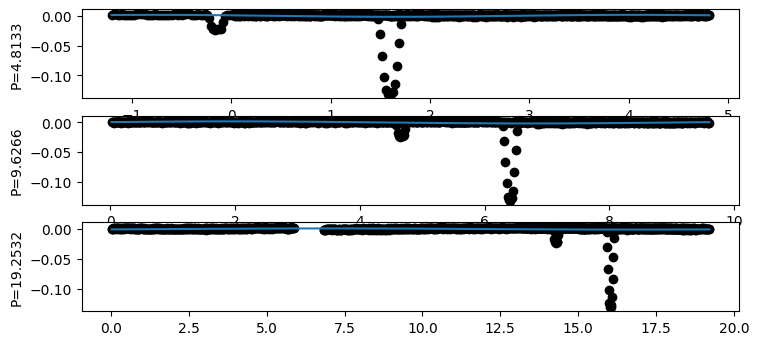

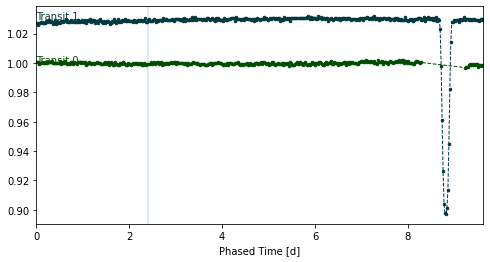

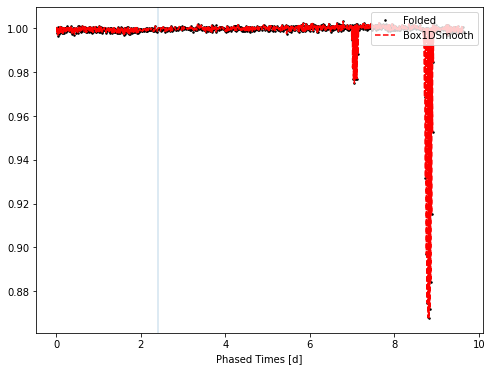

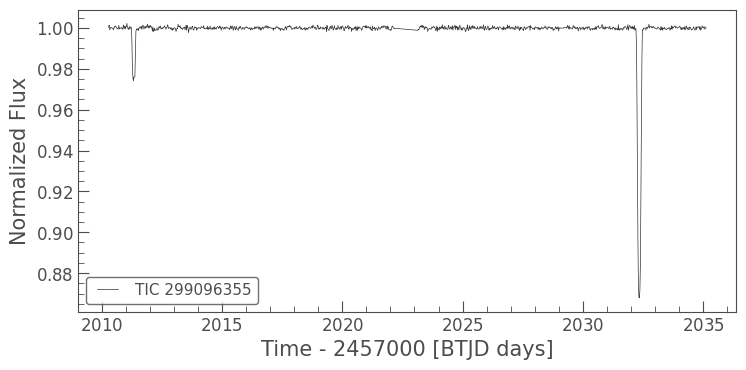

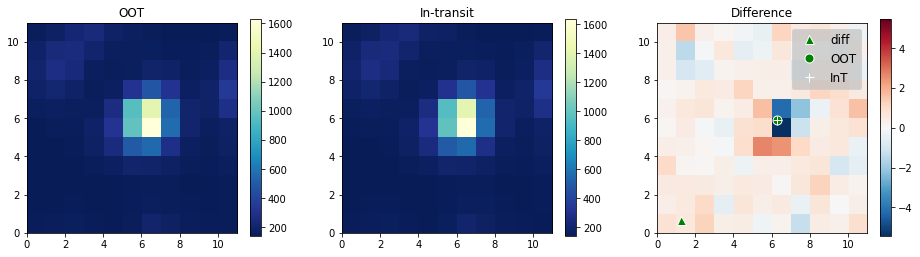

ValueError: need at least one array to concatenate

<Figure size 720x576 with 1 Axes>

In [58]:
i = qlp_high_snr.index[18]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
mask[i] = False #An Knonw Kepler EB

In [ ]:
qlp_high_snr = qlp_tces[mask & (qlp_tces.snr > 15)].copy()
qlp_high_snr

In [ ]:
i = qlp_high_snr.index[3]
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
#mask[i] = False #An Knonw Kepler EB

In [ ]:
bins = np.arange(1,40,.5)

plt.figure()
n,bins, patches = plt.hist(qlp_tces['snr'],bins = bins,histtype='step')
plt.yscale('log')
plt.xlabel('SNR')


plt.figure()
n, bins, patches = plt.hist(qlp_tces['contratio'], histtype='step', bins=np.arange(0,3,.01))
plt.xlabel('Contrast Ratio')

uncrowded = qlp_tces['contratio'] <= 0.2

plt.figure()
n, bins, patchees = plt.hist(qlp_tces[uncrowded]['snr'], histtype='step',bins=np.arange(1,40,.5))
plt.title('uncrowded stars ratio<0.2')
plt.yscale('log')
plt.xlabel('SNR')

bright = qlp_tces['Tmag'] < 11
plt.figure()
n, bins, patchees = plt.hist(qlp_tces[bright]['snr'], histtype='step',bins=np.arange(1,40,.5))
plt.title('bright stars, Tmag<11')
plt.yscale('log')
plt.xlabel('SNR')


In [ ]:
outmask = "/Users/smullally/Science/tess_false_alarms/vet_results/joe_mar_2021/first-dataset/qlp_noebplanets_tces_mask.csv"
np.savetxt(outmask, mask, fmt="%r")

## Keep Going for SNR<15

In [ ]:
qlp_high_snr = qlp_tces[mask & (qlp_tces.snr > 12) &(qlp_tces.snr<=15)].copy()
qlp_high_snr

In [ ]:
mask[1741, 8398, 19740, 19745, 23125, 35471, 35992, 37262, 37872] = 
    [False, False, False, False, False, False, False, False, False]
mask[39973, 40340, 45828, 45828, 49182, 52509, 56275, 57597 ] = 
     [False, False, False, False, False, False, False,]
#Reasons
# poor detrending
# Caught the edge of a known transit
#TIC 138639226,3,14,2.1503,1684.8405,266.659,14.0,0.44, FAIL, -LowSNR--NormLPP-,;CO K06667.01 num:1;CO 6131659 num:1
#CO K06667.01
# poor detrending
#CO K04545.01
# snr is wrong
# TIC 164527785,1,14,2.5339,1684.9413,6851.747,4.0,9.83, FAIL, -OddEvenDetected-,;CO K07082.01 num:11;CO 8736245 
# TIC 164558055,1,14,1.2133,1683.6663,83479.231,4.0,7.51, FAIL, -SWEETHalfPeriod-SWEETAtPeriod,;PC K03218.01 num:23
# CO, corner of an EB
# poor detrending
# ,TIC 170740081,1,14,2.1512,1683.6965,17458.482,2.0,12.68, PASS, ,;CO K06125.01 num:14;CO 5039441
# TIC 184008814,5,15,10.2409,1721.3327,37664.428,14.0,12.95, FAIL, -SWEETHalfPeriod-SWEETAtPeriod-SWEETTwicePeriod-,;CO K04213.01 num:1
# CO, TIC 185109901,1,14,4.3272,1686.3611,40643.542,4.0,14.74, FAIL, -NormLPP-,;CO K06183.01 num:7;CO 8590780 num:4
#


#Interesting
#Unknown match to TIC 26542657.  None of the planets match the TIC, but this is a clear EB. -- Looks like a possible HB star in Kepler. But 11 day EB inTESS
#Kepler KIC 012013550

In [ ]:
i = qlp_high_snr.index[16]+1
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
#cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)
#mask[i] = False #An Knonw Kepler EB

Continue vetting in fas2_analysis.ipynb
